# Statistical Adjustment in Multi-predictor Linear Regression Models

On previous pages, we've seen how to include multiple predictors in our linear regression models. The main advantage of doing this is that it lets us adjust our parameter estimate for one predictor variable in light of other predictor variables. This page will explore more deeply what this concept means and will aim to give you a graphical and statistical intuition for the process.

Recall the English Premier League dataset which we saw [previously](https://lisds.github.io/dsip/epl_modeling.html) has data on English Premier League football clubs. A data scientist may want to get an estimate of the relationship between spending on `forwards` (attacking players) and `goal_difference` (an index of how well the team is performing). Remember that if we only include one predictor in a model, then our estimate will *ignore* other potentially relevant predictor variables. Our data scientist may want to *adjust* their estimate in light of other predictor variables, like spending on `defense` (defending players). This will let our data scientists make statements like "based on our model and the relationships in the data, if two teams spent the same on `defense`, but differed only by one unit in `forward` spending, we would predict that their `goal_difference` would differ by $b$" (where $b$ is the slope for `forward` spending).

You might see this process referred to as "statistical control" in phrases like "*controlling* for predictor variable A, we estimate the slope between predictor B and the outcome variable is...". We'll use the phrase "statistical adjustment" instead, as it refers to the same thing, but to us it keeps the terminology closer to what is actually happening at the level of the model fitting.

Some of the content from this page is touched upon towards end of the other pages, where including multiple predictors was covered, but this page will focus specifically on the topic and offers a more in-depth treatment.

For this page we will use both the Duncan dataset and the English Premier League (EPL) dataset which we have seen previously.  We will use the:

- Duncan data and the EPL data to explore statistical adjustment when using
  numerical predictor variables;
- Duncan data to explore statistical adjustment when using numerical AND
  categorical predictor variables;
- Duncan data to explore statistical adjustment when we ONLY use categorical
  predictor variables.

Because we will be fitting so many models on this page, we will use the following naming convention for each model (e.g. when the model object from `statsmodels` is stored as a python variable:

`dataset_outcome_predictor1_predictor2`

So the text before the first underscore will tell us which dataset the model is fit to (e.g. Duncan or EPL), the text between the first and second underscore will tell us what the outcome variable is,and the text between the underscores at the end of the string will tell us what the predictor variables are.

So for instance, a model fit to the Duncan data, with `prestige` as an outcome and `income` and `education` as predictors (`prestige ~ income + education`) will be stored as a python variable called:

`duncan_prestige_income_education`

Likewise, a model fit to the EPL data, with `goal_difference` as an outcome and `forward` and `defense` as predictors (`goal_difference ~ forward + defense`) will be written as:

`epl_goaldiff_forward_defense`

#### Structure of each section on this page

For each section on this page, we will fit two separate linear regression models. Each of these models will *ignore* the predictor variable used in the other model. We will then combine the predictors in the same multi-predictor model, and see how this affects the parameter estimates (the slopes), so that we can see the process of statistical adjustment in action.

First, let's import the libraries we will need for this page:

In [1]:
# Import numerical and plotting libraries
import numpy as np
import numpy.linalg as npl
import matplotlib.pyplot as plt
import pandas as pd
from jupyprint import jupyprint, arraytex
# Only show 6 decimals when printing
np.set_printoptions(precision=6)
import statsmodels.formula.api as smf
# For interactive widgets.
from ipywidgets import interact
# For interactive Plotly graphs
import plotly.express as px
import plotly.graph_objects as go


# cost function for two predictors (used internally in one of the
# plotting functions)
def ss_two_predictors(bs_and_c, x1_vector, x2_vector, y_vector):
    """ Sum of squares error for intercept and a pair of slopes.
    """
    # unpack the list containing the slope and the intercept (this now has an extra slope!)
    b_1, b_2, c = bs_and_c

    # calculate the fitted values, for this slope/intercept pairing (this now has an extra slope and extra vector!)
    fitted_vector = b_1*x1_vector + b_2*x2_vector + c

    # calculate the error vector (this is the same process as for a single predictor)
    error = y_vector - fitted_vector

    # return the value of the cost function (this is the same process as for a single predictor)
    return np.sum(error ** 2)

Let's read in the Duncan data, for convenience the descriptions of the variables are shown again below:

* `name` - the name of the occupation, from the 1950 US Census
* `type`- type of occupation, with the following categories ``prof``,
  professional and managerial; ``wc``, white-collar; ``bc``, blue-collar. (E.g.
  how the occupation was classified in the 1950 US Census)
* `income` - percentage of census respondents within the occupation who earned
  3,500 dollars or more per year (about 36,000 US dollars in 2017)
* `education` - percentage of census respondents within the occupation who were
  high school graduates
* `prestige` - percentage of respondents in the NORC survey who rated the
  occupation as “good” or better in prestige

See [the dataset
page](https://github.com/odsti/datasets/tree/main/duncan_occupations) for more
detail.

In [2]:
# read in the data
duncan = pd.read_csv("data/Duncan_Occupational_Prestige.csv")

# show the data
duncan

name  type  income  education  prestige
0           accountant  prof      62         86        82
1                pilot  prof      72         76        83
2            architect  prof      75         92        90
3               author  prof      55         90        76
4              chemist  prof      64         86        90
5             minister  prof      21         84        87
6            professor  prof      64         93        93
7              dentist  prof      80        100        90
8             reporter    wc      67         87        52
9             engineer  prof      72         86        88
10          undertaker  prof      42         74        57
11              lawyer  prof      76         98        89
12           physician  prof      76         97        97
13      welfare.worker  prof      41         84        59
14             teacher  prof      48         91        73
15           conductor    wc      76         34        38
16          contractor  prof      53         45        76
17       factory.owner  prof      60         56        81
18       store.manager  prof      42         44        45
19              banker  prof      78         82        92
20          bookkeeper    wc      29         72        39
21        mail.carrier    wc      48         55        34
22     insurance.agent    wc      55         71        41
23         store.clerk    wc      29         50        16
24           carpenter    bc      21         23        33
25         electrician    bc      47         39        53
26         RR.engineer    bc      81         28        67
27           machinist    bc      36         32        57
28      auto.repairman    bc      22         22        26
29             plumber    bc      44         25        29
30   gas.stn.attendant    bc      15         29        10
31          coal.miner    bc       7          7        15
32  streetcar.motorman    bc      42         26        19
33         taxi.driver    bc       9         19        10
34        truck.driver    bc      21         15        13
35    machine.operator    bc      21         20        24
36              barber    bc      16         26        20
37           bartender    bc      16         28         7
38         shoe.shiner    bc       9         17         3
39                cook    bc      14         22        16
40          soda.clerk    bc      12         30         6
41            watchman    bc      17         25        11
42             janitor    bc       7         20         8
43           policeman    bc      34         47        41
44              waiter    bc       8         32        10

We'll be using the full dataset, of 45 occupations. As before, let's
store some of the vectors from the data frame as separate python variables,
so that we can use them more handily:

In [3]:
# store the `prestige` vector
prestige = duncan['prestige'].values

# store the `education` vector
education = duncan['education'].values

# store the `income` vector
income = duncan['income'].values

## Statistical adjustment, with the Duncan data, continuous predictors

Let's run the cell below, to define some custom plotting functions for this page:

In [4]:
# do not worry about the code in this cell, these are just convenience functions to generate plots
def make_scatter(with_errors=False,
                 show=False,
                 return_errors=False,
                 b=1,
                 c=1,
                 x=np.array([]),
                 y= np.array([]),
                 xlabel='',
                 ylabel='',
                 legend_loc=(1, 0.6),
                 continuous_line=False,
                 model_string='',
                 round_to=4):
    plt.scatter(x, y, label='Actual values ($y$)')
    # plot the predicted values
    fitted = b * x + c
    if continuous_line == False:
        plt.plot(x, fitted, 'ro', label='Fitted values from linear regression ($\hat{y}$)')
    elif continuous_line == True:
        x_for_plot = np.linspace(x.min(), x.max())
        fitted_for_plot = b * x_for_plot + c
        plt.plot(x_for_plot, fitted_for_plot, '--', color = 'red', label='Edge of linear regression plane ($\hat{y}$)')
    if with_errors == True:
        # plot the distance between predicted and actual, for all points.
        n = len(x)
        for i in range(n):
            plt.plot([x[i], x[i]], [fitted[i], y[i]], 'k:')
        # the following code line is just to trick Matplotlib into making a new
        # a single legend entry for the dotted lines.
        plt.plot([], [], 'k:', label='Errors ($ \\varepsilon $)')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(model_string+f"\n$b$ = {round(b,round_to)} \n$c$ = {round(c,round_to)} \n Sum of Squared Error = {round(np.sum((y - (b*x + c))**2), 2)}")
    # show the legend
    plt.legend(loc = legend_loc);
    if show == True:
        plt.show()
    # return and show the error vector?
    if return_errors == True:
        errors = y - fitted
        jupyprint(f"Here is the error vector for the current line: {arraytex(np.atleast_2d(errors.round(2)).T)}")
        jupyprint(f"The sum of the squared error is <b> {round(np.sum((errors)**2),2)}. </b>")
        return errors

def make_scatter_line_comparison(b, c):
    # Call the make_scatter function with some defaults.
    errors = make_scatter(with_errors = True,
                          return_errors=True,
                          b = b,
                          c = c,
                          show=True)
    return errors

# do not worry about this code, iit is just to generate the 3D plots
def make_3d_scatter(x1, x2, y,
                    x1_slope=1,
                    x2_slope=1,
                    c =  1,
                    x1_label='',
                    x2_label='',
                    y_label='',
                    return_errors=False,
                    show=True,
                    plane_alpha=0.5,
                    model_string ='',
                    round_to=4,
                    fig_size=(8,8),
                    mx_y=...,
                    min_y=...,
                    x1_1_or_0=False):
    # Create 3D scatterplot
    sum_sq = ss_two_predictors([x1_slope, x2_slope, c], x1, x2, y)
    ax = plt.figure(figsize=fig_size).add_subplot(111, projection='3d')
    ax.scatter(x1,x2,y, label = 'Actual values ($y$)')
    ax.set_xlabel(x1_label)
    if x1_1_or_0 == True:
        ax.set_xticks([0, 1])
    ax.set_ylabel(x2_label)
    ax.set_zlabel(y_label)
    mx_x1 = x1.max()
    mx_x2 = x2.max()
    if mx_y == ...:
        mx_y = y.max()
    min_x1 = np.min([0, x1.min()])
    min_x2 = np.min([0, x2.min()])
    if min_y == ...:
        min_y = np.min([0, y.min()])
    # Plot the fitting plane.
    plane_x = np.linspace(0, mx_x1, 50)
    plane_y = np.linspace(0, mx_x2, 50)
    X, Y = np.meshgrid(plane_x, plane_y)
    Z = c + x1_slope * X + x2_slope * Y
    ax.plot_wireframe(X,Y,Z, color = 'red', label = 'Linear regression plane', alpha = plane_alpha)
    # Plot lines between each point and fitting plane
    for i in np.arange(len(y)):
            x1_point, x2_point, actual = x1[i], x2[i], y[i]
            fitted = c + x1_point * x1_slope + x2_point * x2_slope
            ax.plot([x1_point, x1_point], [x2_point, x2_point], [fitted, actual],
                    linestyle=':',
                    linewidth=0.5,
                    color='black')
    # Add labels to error
    ax.plot([], [], [],
        linestyle=':',
        linewidth=0.5,
        color='black',
        label='Errors ($ \\varepsilon $)')
    # Set the axis limits
    ax.set_xlim(min_x1, mx_x1)
    ax.set_ylim(min_x2, mx_x2)
    ax.set_zlim(min_y, mx_y)
    ax.zaxis.labelpad=-3
    # Show the legend and title
    plt.legend()
    plt.title(model_string+f"\n$b_1$ = {round(x1_slope,round_to)} \n$b_2$ = {round(x2_slope,round_to)} \n$c$ = {round(c,round_to)} \n Sum of Squared Error = {round(sum_sq, 2)}")
    if show == True:
        plt.show()
    if return_errors == True:
        fitted = c + x1_slope * x1 + x2_slope*x2
        errors = y - fitted
        jupyprint(f"Here is the error vector for the current regression plane: {arraytex(np.atleast_2d(errors.round(2)).T)}")
        jupyprint(f"The sum of the squared error is <b> {round(np.sum((errors)**2), 2)} </b>.")
        return errors


def plotly_3D_with_plane(dataset, x1_string, x2_string, y_string, hover_string_list,
                         x1_slope, x2_slope, intercept, model_title_string='',
                        x1_1_or_0=False):
    """Interactive 3D scatter, via plotly."""
    # create the scatterplot
    scatter_3d = px.scatter_3d(dataset, x=x1_string, y=x2_string, z=y_string,
                              hover_data= hover_string_list)
    # generate the regression plane
    x1 = scatter_3d.data[0].x
    x2 = scatter_3d.data[0].y
    x1, x2 = np.meshgrid(x1, x2)
    y = x1_slope * x1 + x2_slope * x2 + intercept
    scatter_3d.add_trace(go.Surface(x=x1, y=x2, z=y, opacity=0.2))

    # generate fitted values
    predicted_values = intercept + x1_slope * scatter_3d.data[0].x + x2_slope * scatter_3d.data[0].y

    # calculate errors
    errors = scatter_3d.data[0].z - predicted_values

    # add errors to the plot
    for i in np.arange(len(dataset)):
        scatter_3d.add_trace(go.Scatter3d(
            x = [scatter_3d.data[0].x[i], scatter_3d.data[0].x[i]],
            y = [scatter_3d.data[0].y[i], scatter_3d.data[0].y[i]],
            z = [scatter_3d.data[0].z[i], predicted_values[i]],
            mode='lines', showlegend=False,
            line={'color': 'black', 'dash':'dash'}))
    # add a title to the plot
    scatter_3d.update_layout(title=model_title_string)

    # adjust view angle (to same default as matplotlib)
    scatter_3d.update_layout(scene={'camera': {'up': {'x': 0, 'y': 0, 'z': 1},
                                    'center': {'x': 0, 'y': 0, 'z': 0},
                                    'eye': {'x': 1.6, 'y': -1.6, 'z': 0.6}}})
    if x1_1_or_0==True:
        scatter_3d.update_layout(scene = {'xaxis': {"tickvals":[0, 1]}})

    # show the plot
    scatter_3d.show()

def plot_model_3D(x1_slope, x2_slope, c, return_errors = True, fig_size = (8, 8), round_to=4):
    errors = make_3d_scatter(education, income, prestige,
               x1_slope=x1_slope,
               x2_slope=x2_slope,
               c = c,
               return_errors=return_errors,
               x1_label="Education",
               x2_label="Income",
               y_label="Prestige",
               fig_size=fig_size,
               round_to=round_to)
    return errors

### Prestige ~ Education

Let's fit one of the models we've seen before, showing the linear relationship between `prestige` and `education`, if we ignore `income`. E.g. if we fit a single-predictor linear regression of the form `prestige ~ education`.

We could write this model more fully as:

`prestige` = $b * $ `education` + $ \text{c} + \vec{\varepsilon} $

You'll recall that, because this is a *single-predictor* regression model, we get one slope ($b$) and the one intercept ($c$). Whatever method we use for fitting the regression model, it will return the slope/intercept pair which give the error vector ($\vec{\varepsilon}$) which gives the lowest sum of the squared error.

We'll use the `statsmodels.formula` library to fit our model, using the syntax we've seen previously (this is a very useful interface for quickly fitting and comparing lots of different models).

We'll save the model as `duncan_prestige_education`, which, as detailed above, we can read as "a model fit to the Duncan dataset, with `prestige` as an outcome and `education` as a predictor:

In [5]:
# fit our first model (`prestige` ~ `education`)
duncan_prestige_education = smf.ols('prestige ~ education', data = duncan).fit()

# show the summary of our model (`slim=True` gives us a briefer summary of the model)
duncan_prestige_education.summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               prestige   R-squared:                       0.726
Model:                            OLS   Adj. R-squared:                  0.719
No. Observations:                  45   F-statistic:                     113.8
Covariance Type:            nonrobust   Prob (F-statistic):           1.17e-13
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2840      5.093      0.056      0.956      -9.987      10.555
education      0.9020      0.085     10.668      0.000       0.731       1.073
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

For all the `statsmodels` summary tables we see on this page, the most important part to attend to is the `coef` column, which is highlighted in red below:

![](images/stat_table.png)

The numbers here are our parameter estimates (they are different to the slope/intercept we obtained when we fit this model to the first 15 rows of the Duncan dataset previously).

Let's pull out the slope and intercept from this model, and store them as separate variables:

In [6]:
# get the slope, from the statsmodels model object
duncan_prestige_education_slope = duncan_prestige_education.params['education'].round(4)

# show the slope
duncan_prestige_education_slope

0.902

In [7]:
# get the intercept, from the statsmodels model object
duncan_prestige_education_intercept = duncan_prestige_education.params['Intercept'].round(4)

# show the intercept
duncan_prestige_education_intercept

0.284

Let's plot the data and the fitted values from the model. (*Note:* normally it is best practice to plot the data *before* fitting a model, but we'll be fitting lots of models on this page, and the emphasis is on statistical adjustment, so to save time we will plot the model and the data together, in the first instance):

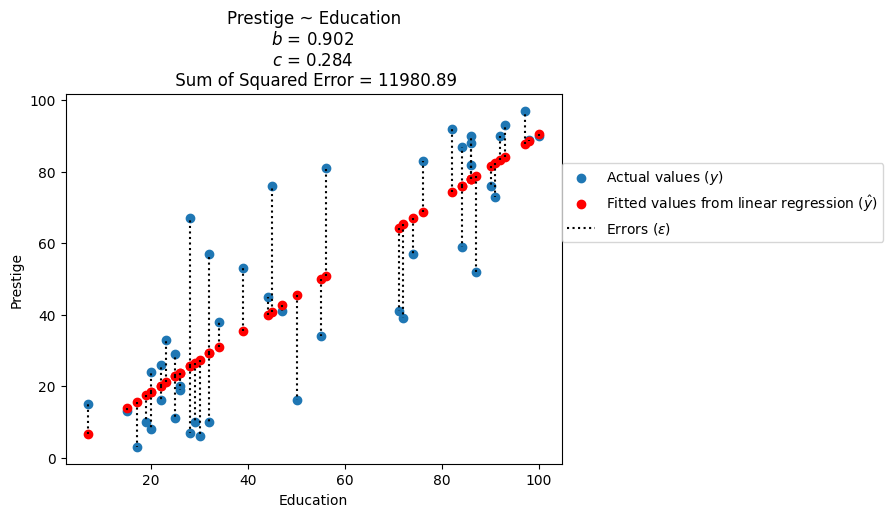

In [8]:
# do not worry about this code, it is just a convenience function to generate the plot
def plot_prestige_education(continuous_line=False):
    make_scatter(x=education,
    y=prestige,
    b=duncan_prestige_education_slope,
    c=duncan_prestige_education_intercept,
    xlabel='Education',
    ylabel='Prestige',
    with_errors=True,
    model_string='Prestige ~ Education',
    continuous_line=continuous_line)

plot_prestige_education()

We can see that, ignoring `income`, there is a clear linear relationship
between `education` and `prestige`. As with any single-predictor linear
regression, the slope of the predictor (`education`) has not been adjusted in
light of any of the other predictor variables.

Now, let's fit another single-predictor linear regression, describing the
linear relationship between `income` and `prestige`. Again, this regression
will *not* adjust it's estimate of the slope between `income` and `education`
in light of any other predictor variables.

Before we fit this second model however, let's define a function that will fit
the model for us.

We'll be fitting lots of models on this page, and a good principle when coding
is "don't repeat yourself".

E.g. if you will be using the same procedure many times, write a function to do
it:

In [9]:
# a function to fit a single predictor linear regression, using the `statsmodels.formula` library
def fit_single_pred_model(model_spec_string,
                          dataset,
                          slope_name,
                          slim_summary=True):
    """A function to fit a single predictor linear regression,
    using the `statsmodels.formula` library
    """

    # fit the model, based on the `model_spec_string`, and the `dataset`
    model = smf.ols(model_spec_string, data = dataset).fit()

    # show the (slim) model summary
    display(model.summary(slim=slim_summary))

    # store the intercept
    intercept = model.params['Intercept'].round(4)

    # store the slope
    slope = model.params[slope_name].round(4)

    # return the model object, the intercept and the slope
    return model, intercept, slope

In [10]:
# test the function, with the model we just fitted (`prestige ~ education`)
test_model, test_intercept, test_slope = fit_single_pred_model(
    'prestige ~ education',
    duncan,
    'education')

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               prestige   R-squared:                       0.726
Model:                            OLS   Adj. R-squared:                  0.719
No. Observations:                  45   F-statistic:                     113.8
Covariance Type:            nonrobust   Prob (F-statistic):           1.17e-13
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2840      5.093      0.056      0.956      -9.987      10.555
education      0.9020      0.085     10.668      0.000       0.731       1.073
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

To "sanity check" our function, the two cells below test the intercept/slope
that we get from our function against those we stored earlier.

If the tests pass, the cells will run without producing an error,
in which case our function has returned the same parameter estimates
as those we stored earlier.

In [11]:
# test the intercept
assert test_intercept == duncan_prestige_education_intercept

In [12]:
# test the slope
assert test_slope == duncan_prestige_education_slope

### Prestige ~ Income

Now, let's look at the unadjusted slope for a linear regression predicting `prestige` from `income`.

We could write this model as:

`prestige` = $b * $ `income` + $ \text{c} + \vec{\varepsilon} $

We'll use the function we just defined. The expression the left hand side of the `=` just implements the unpacking process we've seen previously. Our function returns three elements (the model, the intercept and the slope). Placing these three elements between parentheses `()` just let's us split the code over multiple lines, to make it more readable:

In [13]:
# fit the `prestige ~ income` model
(duncan_prestige_income,
 duncan_prestige_income_intercept,
 duncan_prestige_income_slope) = fit_single_pred_model('prestige ~ income', duncan, slope_name = 'income')

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               prestige   R-squared:                       0.702
Model:                            OLS   Adj. R-squared:                  0.695
No. Observations:                  45   F-statistic:                     101.3
Covariance Type:            nonrobust   Prob (F-statistic):           7.14e-13
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.4566      5.190      0.473      0.638      -8.010      12.923
income         1.0804      0.107     10.062      0.000       0.864       1.297
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Let's plot the data and the fitted values from the `prestige ~ income` model:

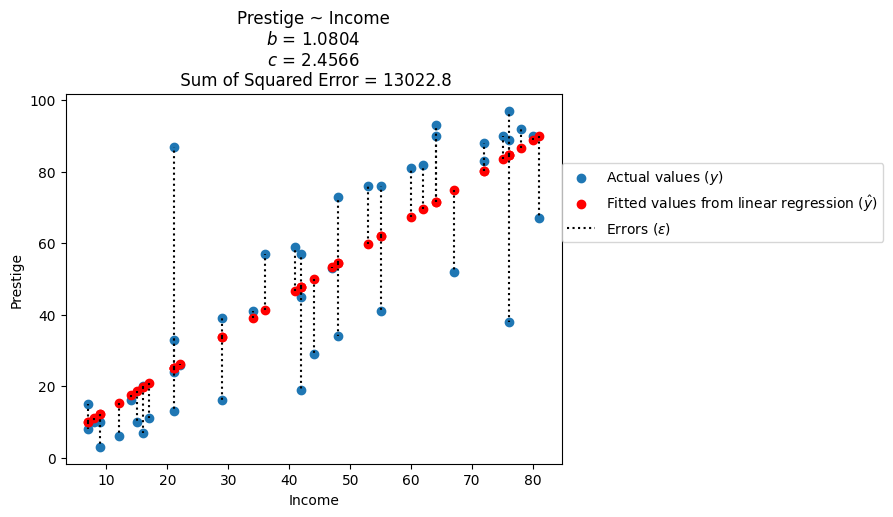

In [14]:
# another convenience plotting function
def plot_prestige_income(continuous_line=False):
    make_scatter(x=income,
    y=prestige,
    b=duncan_prestige_income_slope,
    c=duncan_prestige_income_intercept,
    xlabel='Income',
    ylabel='Prestige',
    with_errors=True,
    model_string='Prestige ~ Income',
    continuous_line=continuous_line)

plot_prestige_income()

We can see that there is a clear linear relationship between `income` and `prestige`. Note again that the slope has *not* been adjusted with reference to other potential predictor variables (like `education`).

So, now we have two models:

`prestige ~ education`

...and...

`prestige ~ income`
______________________________________________
Or, written more fully:


`prestige` = $b * $ `education` + $ \text{c} + \vec{\varepsilon} $

...and...


`prestige` = $b * $ `income` + $ \text{c} + \vec{\varepsilon} $

The slope that we get from each model is an estimate of the linear relationship between the predictor variable and the outcome variable, if we *ignore* the other predictor variable

Let's include them in the same model, and see how the adjustment process works (e.g. what happens to the slope of each predictor when we statistically adjust each slope in light of the other predictor variable).

First, let's show the data in 3D. This plot shows `prestige` as a function of `education` and `income`.
To keep things simple, we'll refer to each axis by the name of the predictor that it shows.

So, the first horizontal axis is the `education` axis.
The second horizontal axis is the `income` axis.
The vertical axis is the `prestige` axis.

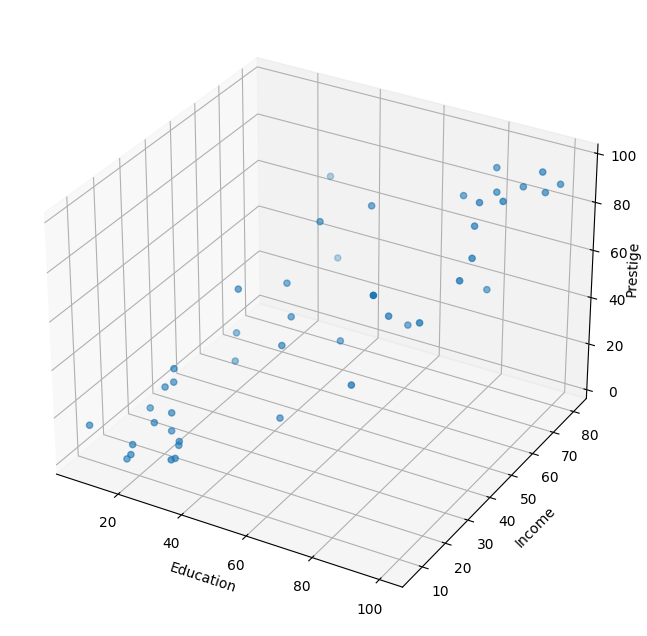

In [15]:
# do not worry about the details of this code, it just generates the 3D scatterplot
def basic_3D_scatter():
    fig = plt.figure(figsize = (8, 8))
    ax = fig.add_subplot(projection='3d')
    ax.scatter(education, income, prestige)
    ax.set_xlabel('Education')
    ax.set_ylabel('Income')
    ax.set_zlabel('Prestige')
    ax.zaxis.labelpad=-3
    plt.show()

basic_3D_scatter()

Just as on the scatterplots we've seen that show two variables, each datapoint
represents one occupation (one observational unit).

The `education` axis location of each datapoint is given by the `education`
score of that observational unit.

The `income` axis location of each datapoint is given by the `income` score of
that observational unit.

The `prestige` axis location of each datapoint is given by the `prestige` score
of that observational unit.

Let's remind ourselves what is happening when we fit a linear regression model
with two predictors. With two predictors, we are fitting a *plane* (like
a sheet of paper) rather than a *line*. The model is still linear though, for
reasons we are about to see.

First, let's remind ourselves what "fitting a plane" looks like.

If you are using this page interactively, you can change the slope for `education`, the slope for `income` and the intercept, to see how this affects the location/orientation of the plane, and the value of the cost function (the sum of squared error).

The full vector notation for the model is also shown below the plot (though as we are using 45 observational units now, it is hard to read - you may have to zoom out!).

**Note**: we really recommend spending some time interacting with this plot, in the following manner:

- adjust the intercept only, see how this affects the plane
- adjust the `education_slope` only, see how this affects the plane (ensure the `income_slope` is set to 0)
- adjust the `income_slope` only, see how this affects the plane (ensure the `education_slope` is set to 0)
- set both the slopes to nonzero values, and then experiment with the sign of each slope (make one positive, and the other negative etc.)

Being able to understand the meaning of the slopes in 3D is **key** to getting a graphical intuition for statistical adjustment, so please do experiment with this plot:

In [16]:
# do not worry about this code, it just generates the interactive plot
def interactive_plane_fitter(education_slope, income_slope, intercept):

    # calculate the fitted values, for this combination of parameter estimates
    fitted = education_slope * education + income_slope * income + intercept

    # calculate the errors, for this combination of parameter estimates
    errors = prestige - fitted

    # compare the best fitting plane to the one generated by our guessed parameters
    errors3d_from_guesses = plot_model_3D(x1_slope = education_slope,
                                          x2_slope=income_slope,
                                          c = intercept,
                                          return_errors=False,
                                          fig_size=(6, 6))

    # do not worry about this code, it just prints the mathematical notation below this cell
    jupyprint(f"${arraytex(np.atleast_2d(fitted + errors).T)} = {round(education_slope, 2)} * {arraytex(np.atleast_2d(education).T)} + {round(income_slope, 2)} * {arraytex(np.atleast_2d(income).T)} + {round(intercept, 2)} + {arraytex(np.atleast_2d(errors).round(2).T)}$")
    jupyprint(f"The sum of the squared errors for this combination of parameter estimates is <b> {np.sum(errors**2)} </b>")

interact(interactive_plane_fitter, education_slope = (-2, 2, 0.1), income_slope = (-2, 2, 0.1), intercept = (-100, 100, 0.1))

interactive(children=(FloatSlider(value=0.0, description='education_slope', max=2.0, min=-2.0), FloatSlider(va…

<function __main__.interactive_plane_fitter(education_slope, income_slope, intercept)>

Now, we've given ourselves a good graphical intuition for the fitting of a plane, here is another **key** cornerstone of understanding statistical adjustment, from a graphical perspective.

The distribution of points on the 3D scatterplot is *fixed* - it is given by
the values in our dataset.

The 3D distribution of points exists **irrespective of our model**.

So, if we fit a model that only factors in one predictor variable and ignores the other, the distribution of points on the 3D scatter remains unchanged:

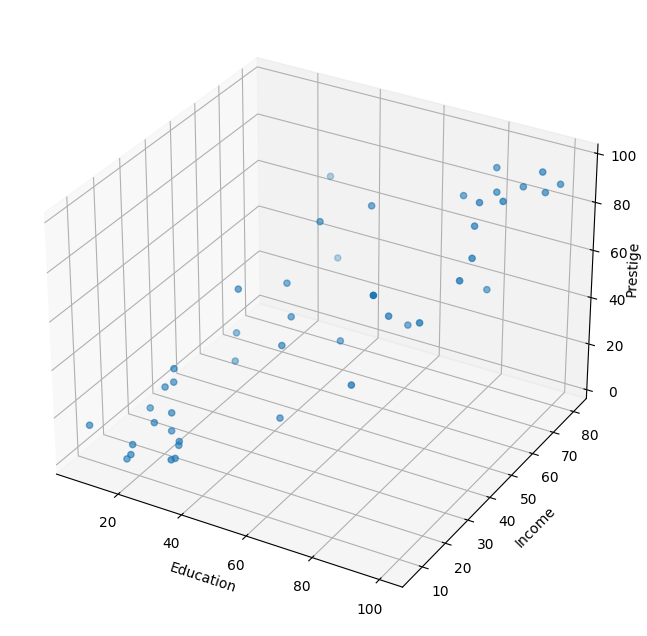

In [17]:
# generate the 3D scatter
basic_3D_scatter()

Now, on the interactive scatterplot we just used above, we can set one of the
slopes to 0.

We could then set the other slope and the intercept to be the value of the slope and the intercept that we got from a single-predictor linear regression.

So for instance, we could set the `income_slope` to 0, and then we could set the `education_slope` and the `intercept` to be the values we got from our single-predictor linear regression (`prestige ~ education`).

Let's remind ourselves of these values:

In [18]:
# show the `prestige ~ education` intercept
duncan_prestige_education_intercept

0.284

In [19]:
# show the `prestige ~ education` slope
duncan_prestige_education_slope

0.902

Please feel free to try and input these values on the interactive scatterplot above, but make sure you set the `income_slope` to 0.

The output of the code cell below shows the graph we obtain from these "settings" - the value of the slopes and intercept are shown above the plot. Please compare them to the values shown in the two cells above this cell.

$b_1$ is the slope for the `education` axis.
$b_2$ is the slope for the `income` axis (it is set to 0 in this case)
$c$ is the value of the intercept:

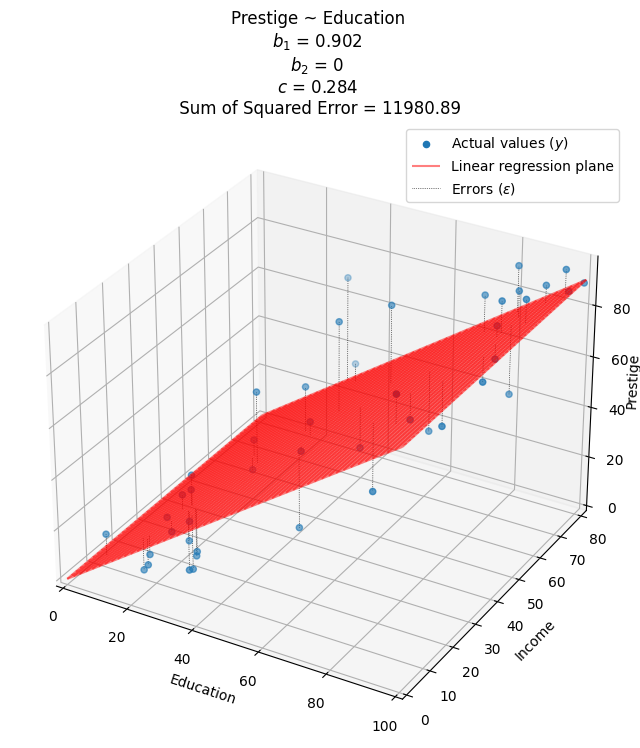

In [20]:
make_3d_scatter(x1=education,
                x2=income,
                y=prestige,
                x1_slope=duncan_prestige_education_slope,
                x2_slope=0,
                c=duncan_prestige_education_intercept,
                model_string='Prestige ~ Education',
                x1_label='Education',
                x2_label='Income',
                y_label='Prestige')

Now, we'd like you to imagine the scatterplot as a physical object. Maybe it could be an exhibit in an art gallery, or maybe a 3D hologram in a fancy data visualisation space.

Now imagine you were standing on the `education` axis, facing the "back wall" of the plot, something like this somewhat ghostly figure shown below (the direction the figure is looking in is shown by a blue arrow):

![](images/stat_adjust_duncan_ed.png)

(*Note*: the value of the slope and intercept have been rounded on the above image, but they are the slope/intercept from the `prestige ~ education` model).

Now, if we assume you had quite bad depth perception, and were standing at exactly the right place on the `education` axis, you would see something like this (where the dashed red line would be the "edge" of the regression plane):

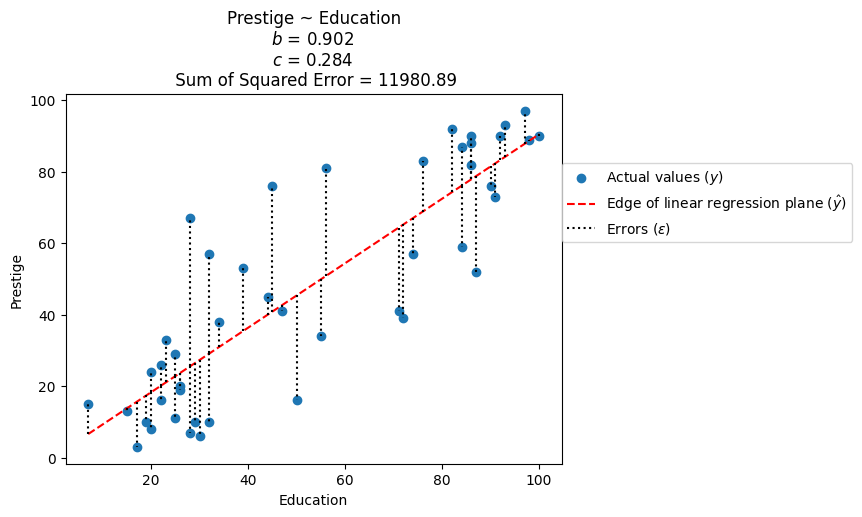

In [21]:
# generate the perspective you would see, standing on the `education` axis
plot_prestige_education(continuous_line=True)

Please scroll back and forth between this plot, and the plot above (with the image of the figure standing on the `education` axis) - until you are convinced by this.

The key message is this: **a line can be thought of as a 2D "slice" of a 3D plane**.

So, we can take the parameter estimates (the slope $b$ and the intercept $c$) from a single-predictor linear regression (like `prestige ~ education`), and show them on a 3D plot. We do this by setting the slope of the other predictor (in this case `income`) to 0 - this is the same as not including `income` in the model.

If you compare the value of the sum of the squared error shown above the last two scatterplots, you will see that it is the same, whether we shown linear regression as a line in 2D or as a plane in 3D.

**Pause for thought**: let's pause here to make sure we really understand these concepts, as they are somewhat tricky/mind-bendy at first.

It is very important to understand these concepts before we proceed:

- fitting a single predictor linear regression *ignores* other predictor variables in the dataset
- the parameter estimates (the slope $b$ and the intercept $c$) from the single predictor linear regression can be shown as a line in 2D, or as a plane in 3D
- if we show them as a plane in 3D, and the slope of the other predictor is 0, we get *exactly* the same errors as for the 2D line

This process let's us show a single-predictor linear regression in 3D, by *ignoring* the other predictor.

We can then see how the regression plane looks *when we do **not** statistically adjust for the other predictor*.

We will now fit a multi-predictor linear regression model, so we can see how the process of statistical adjustment affects the regression plane.

### Prestige ~ Education + Income

Let's now fit the following model:

`prestige ~ education + income`

Or, written more fully:


`prestige` = $b_1 * $ `education` + $b_1 * $ `income` $ \text{c} + \vec{\varepsilon} $

Because the model now includes both predictors in the fitting process, we get two slopes:

- $b_1$ the slope of the first predictor (`education`)
- $b_2$ the slope of the second predictor (`income`)

These slopes will very likely be different from the slopes we got from the two separate linear regression models, as we are now *adjusting* each slope in light of the other predictor variable. (We will see soon what this means, in more detail).

First, let's fit the model:

In [22]:
# for the `prestige ~ education + income` model
duncan_prestige_education_income = smf.ols('prestige ~ education + income', data = duncan).fit()

# show the model summary
duncan_prestige_education_income.summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               prestige   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.820
No. Observations:                  45   F-statistic:                     101.2
Covariance Type:            nonrobust   Prob (F-statistic):           8.65e-17
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -6.0647      4.272     -1.420      0.163     -14.686       2.556
education      0.5458      0.098      5.555      0.000       0.348       0.744
income         0.5987      0.120      5.003      0.000       0.357       0.840
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Now, as above, in keeping with the good practice of "don't repeat yourself", let's modify our model-fitting function to accept two predictor variables, as we will be repeating this process later on this page:

In [23]:
# a modified model-fitting function, which now accepts two predictor vectors
def fit_model(model_spec_string,
              dataset,
              slope_names_list,
              slim_summary=True):
    """A function to fit a two predictor linear regression,
    using the `statsmodels.formula` library.
    """

    # fit the model, based on the `model_spec_string`, and the `dataset`
    model = smf.ols(model_spec_string, data = dataset).fit()

    # show the (slim) model summary
    display(model.summary(slim=slim_summary))

    # store the intercept
    intercept = model.params['Intercept']

    # if fitting a single predictor model, return the model
    # the intercept, and the single slope
    if len(slope_names_list) == 1:

        slope = model.params[slope_names_list[0]]

        return model, intercept, slope

    # if fitting a two-predictor model, return the model,
    # the intercept, and the two slopes
    if len(slope_names_list) == 2:

        slope_1 = model.params[slope_names_list[0]]

        slope_2 = model.params[slope_names_list[1]]

        return model, intercept, slope_1, slope_2

As we did with the previous model-fitting function, let's check it is producing the same
estimates as the ones we just got when we fit the `prestige ~ education + income` model just now).

As before, if this cell runs without errors, then the tests have passed:

In [24]:
# generate test parameters
test_model, test_intercept, test_slope_1, test_slope_2 = fit_model('prestige ~ education + income',
                                                         duncan,
                                                         ['education', 'income'])

# perform the tests
assert test_intercept == duncan_prestige_education_income.params['Intercept']
assert test_slope_1 == duncan_prestige_education_income.params['education']
assert test_slope_2 == duncan_prestige_education_income.params['income']

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               prestige   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.820
No. Observations:                  45   F-statistic:                     101.2
Covariance Type:            nonrobust   Prob (F-statistic):           8.65e-17
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -6.0647      4.272     -1.420      0.163     -14.686       2.556
education      0.5458      0.098      5.555      0.000       0.348       0.744
income         0.5987      0.120      5.003      0.000       0.357       0.840
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Let's fit the `prestige ~ education + income` model using our function, now
we have tested it:

In [25]:
# fit the model using our function
(duncan_prestige_education_income,
 duncan_prestige_education_income_intercept,
 duncan_prestige_education_income_ed_slope,
 duncan_prestige_education_income_inc_slope) = fit_model('prestige ~ education + income',
                                                         duncan,
                                                         ['education', 'income'])

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               prestige   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.820
No. Observations:                  45   F-statistic:                     101.2
Covariance Type:            nonrobust   Prob (F-statistic):           8.65e-17
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -6.0647      4.272     -1.420      0.163     -14.686       2.556
education      0.5458      0.098      5.555      0.000       0.348       0.744
income         0.5987      0.120      5.003      0.000       0.357       0.840
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

You'll notice that the slopes from this model, for each predictor variable, are different to those we obtained from the two single-predictor models.

The cell below shows the slopes for all the models fit so far (all the slopes are rounded to 4 decimal places):

In [26]:
# do not worry about this code, it just generates the printout
jupyprint('### Single Predictor Models')
jupyprint(f"For the model `prestige ~ education`, the `education` slope = <b> {round(duncan_prestige_education_slope, 4)} </b>")
jupyprint(f"For the model `prestige ~ income`, the `income` slope = <b> {round(duncan_prestige_income_slope, 4)} </b>")
jupyprint('____________________________________\n### Multi-Predictor Model')
jupyprint(f"For the model `prestige ~ education + income`, the `education` slope = <b> {round(duncan_prestige_education_income_ed_slope, 4)} </b>")
jupyprint(f"For the model `prestige ~ education + income`, the `income` slope = <b> {round(duncan_prestige_education_income_inc_slope, 4)} </b>")

### Single Predictor Models

For the model `prestige ~ education`, the `education` slope = <b> 0.902 </b>

For the model `prestige ~ income`, the `income` slope = <b> 1.0804 </b>

____________________________________
### Multi-Predictor Model

For the model `prestige ~ education + income`, the `education` slope = <b> 0.5458 </b>

For the model `prestige ~ education + income`, the `income` slope = <b> 0.5987 </b>

The slopes from the single predictor models are different from the slopes in the multi-predictor model because the fitting process has now *adjusted* each slope in light of the other predictor variable.

But what does this mean? It is easiest to understand graphically.

Let's plot the regression plane for the `prestige ~ education + income` model:

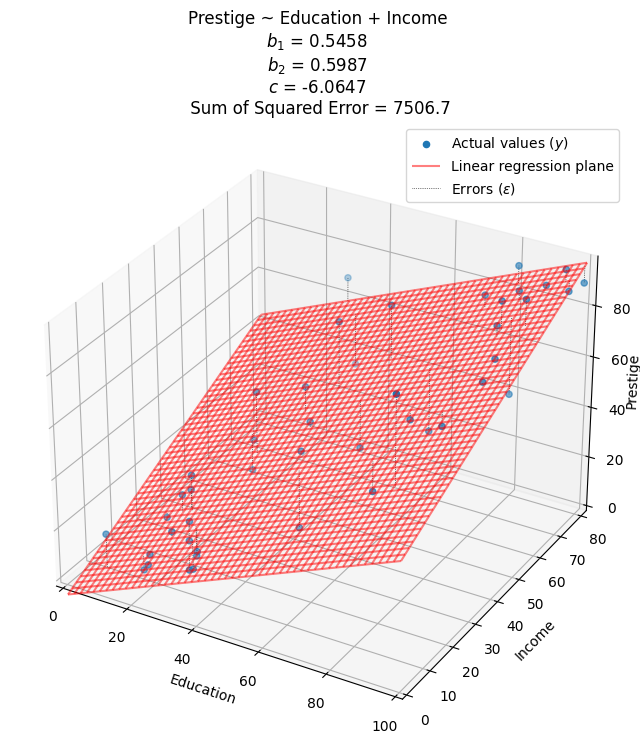

In [27]:
# do not worry about this code, it just generates the 3D scatterplot
make_3d_scatter(education,
                income,
                prestige,
                x1_slope=duncan_prestige_education_income_ed_slope,
                x2_slope=duncan_prestige_education_income_inc_slope,
                c=duncan_prestige_education_income_intercept,
                x1_label='Education',
                x2_label='Income',
                y_label='Prestige',
                model_string='Prestige ~ Education + Income')

Now, remember earlier we saw that we can display the single-predictor linear regression in 3D, by taking the parameter estimates (the slope and the intercept) from the single-predictor regression, and setting the slope of the other predictor to 0?

The cell below will generate three 3D plots.

The first (leftmost) plot will show the `prestige ~ education` model, in 3D (where the regression plane is generated only from the parameter estimates of the `prestige ~ education` model).

The middle plot will show the `prestige ~ income` model, in 3D (where the regression plane is generated only from the parameter estimates of the `prestige ~ income` model).

The last (rightmost) plot will show the `prestige ~ education + income` model, in 3D (where the regression plane is generated using the parameter estimates from the multi-predictor model):

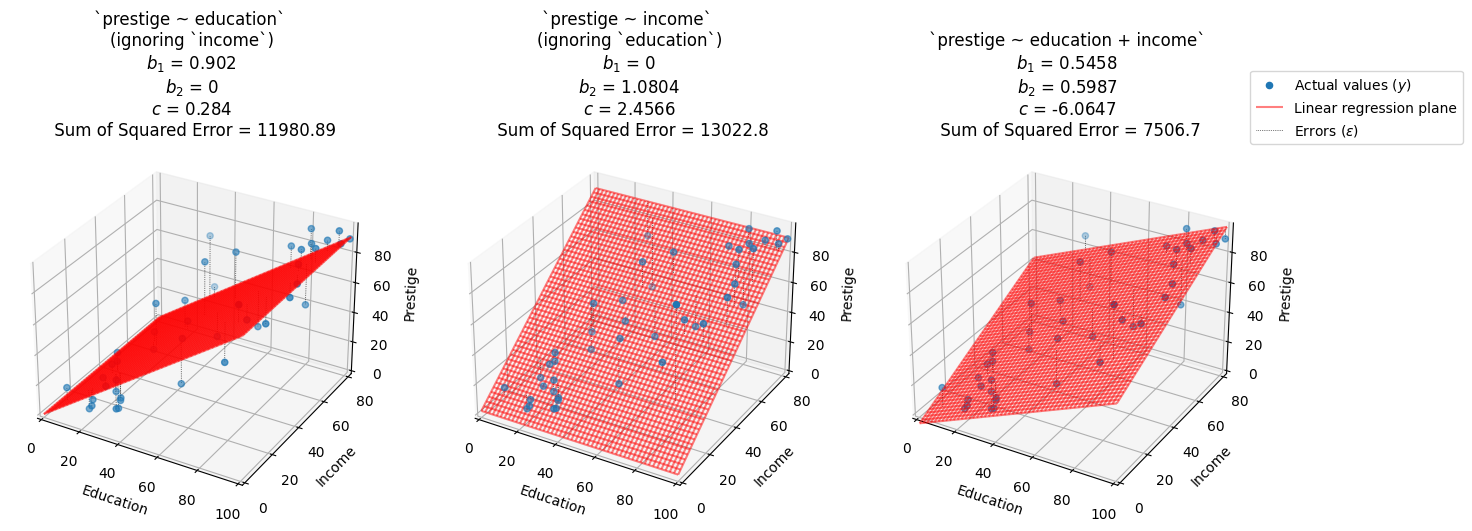

In [28]:
# do not worry about this code, it is just to generate the 3D plots
def single_multi_comparison_subplots(
    x1=education,
    x2=income,
    y=prestige,
    x1_label = 'Education',
    x2_label='Income',
    y_label='Prestige',
    plane_alpha=0.5,
    x1_0_and_1=False,
    x2_0_and_1=False,
    round_to=4,
    mx_y=...,
    min_y=...,
    model_strings=["`prestige ~ education` \n(ignoring `income`)",
                     "`prestige ~ income` \n(ignoring `education`)",
                     "`prestige ~ education + income`"],
    x1_slopes=[duncan_prestige_education_slope, 0, duncan_prestige_education_income_ed_slope],
    x2_slopes=[0, duncan_prestige_income_slope, duncan_prestige_education_income_inc_slope],
    cs=[duncan_prestige_education_intercept, duncan_prestige_income_intercept,
          duncan_prestige_education_income_intercept]):
    # set up the plot object
    fig, axes = plt.subplots(1, 3, figsize=(16, 10), subplot_kw={'projection': '3d'})
    # iterate over the subplot locations, slope lists and intercept list
    for num, (subplot_val, x1_slope, x2_slope, c) in enumerate(zip([131, 132, 133],
                                                               x1_slopes,
                                                               x2_slopes,
                                                               cs)):
        # generate the subplot
        sum_sq = ss_two_predictors([x1_slope, x2_slope, c], x1, x2, y)
        ax = axes[num]
        ax.scatter(x1,x2,y, label = 'Actual values ($y$)')
        if x1_0_and_1 == True:
            ax.set_xticks([0, 1])
        if x2_0_and_1 == True:
            ax.set_yticks([0, 1])
        ax.set_xlabel(x1_label)
        ax.set_ylabel(x2_label)
        ax.set_zlabel(y_label)
        mx_x1 = x1.max()
        mx_x2 = x2.max()
        if mx_y == ...:
            mx_y = y.max()
        min_x1 = np.min([0, x1.min()])
        min_x2 = np.min([0, x2.min()])
        if min_y == ...:
            min_y = np.min([0, y.min()])
        # plot the fitting plane.
        plane_x = np.linspace(min_x1, mx_x1, 50)
        plane_y = np.linspace(min_x2, mx_x2, 50)
        X, Y = np.meshgrid(plane_x, plane_y)
        Z = c + x1_slope * X + x2_slope * Y
        ax.plot_wireframe(X,Y,Z, color = 'red', label = 'Linear regression plane', alpha = plane_alpha)
        # plot lines between each point and fitting plane
        for i in np.arange(len(y)):
            x1_point, x2_point, actual = x1[i], x2[i], y[i]
            fitted = c + x1_point * x1_slope + x2_point * x2_slope
            ax.plot([x1_point, x1_point], [x2_point, x2_point], [fitted, actual],
                    linestyle=':',
                    linewidth=0.5,
                    color='black')
        # add labels to error
        ax.plot([], [], [],
            linestyle=':',
            linewidth=0.5,
            color='black',
            label='Errors ($ \\varepsilon $)')
        # set the axis limits
        ax.set_xlim(min_x1, mx_x1)
        ax.set_ylim(min_x2, mx_x2)
        ax.set_zlim(min_y, mx_y)
        ax.set_title(f"{model_strings[num]}\n$b_1$ = {round(x1_slope,round_to)} \n$b_2$ = {round(x2_slope,round_to)} \n$c$ = {round(c,round_to)} \n Sum of Squared Error = {round(sum_sq, 2)}")
    plt.legend(loc = (1,  1))

single_multi_comparison_subplots()

Now, once again, let's imagine these plot as physical objects, where you could stand on one axis and look at one of the "walls" of the plot.

The image below shows two people (one of whom we met earlier) standing on the different axes of the plot:

![](images/stat_adjust_duncan_ed_inc.png)

Let's "zoom" in on the leftmost graph, and think what the person standing on the `education` axis would see:

![](images/stat_adjust_duncan_ed.png)

As mentioned above, assuming the person was standing in the right location, they would see something like (compare the slope, intercept and sum of the squared error values above both of the graphs also):

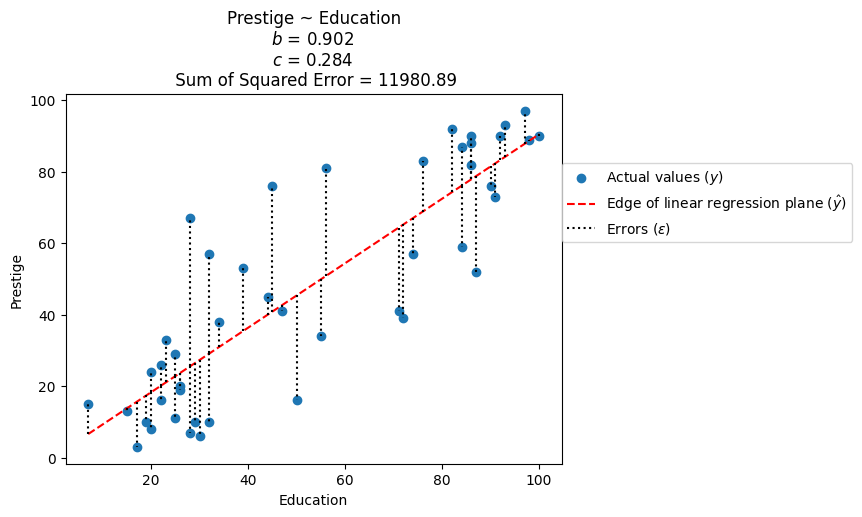

In [29]:
# generate what the person on the `education` axis would see
plot_prestige_education(continuous_line=True)

Now, let's "zoom in" on the middle graph, and think what the person standing on the `income` axis would see:

![](images/stat_adjust_duncan_inc.png)

They would see something like this (once again, compare the slope, intercept and sum of the squared error values above both of the graphs also):

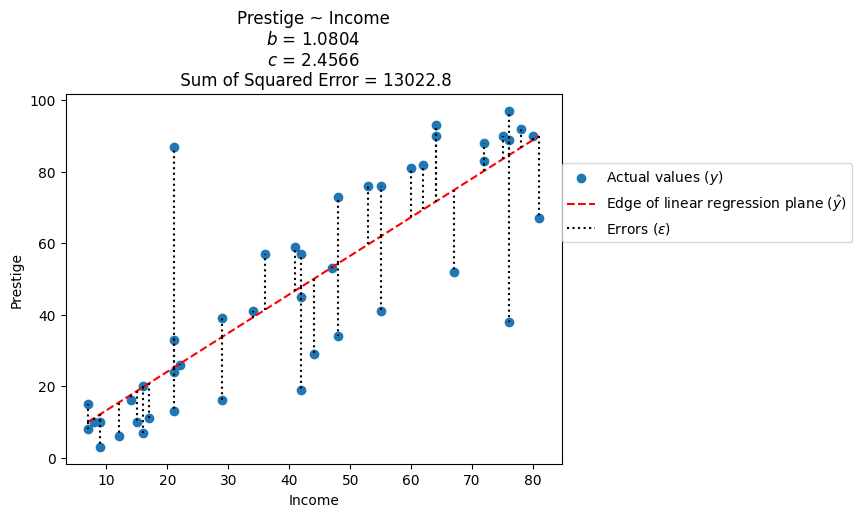

In [30]:
# show what the person standing on the `income` axis would see
plot_prestige_income(continuous_line=True)

The first two plots show us the *unadjusted* estimates of the linear relationship between each predictor and the outcome variable.

The reason that the "view from one of the axes" for the first two graphs is *identical* to the 2D scatterplot, is that the single-predictor model **ignores information from the other predictor**. So the regression line (or plane, in 3D) is fit only **with reference to the distance from the points along one axis**.

Look at the difference between the regression planes of the first two plots (unadjusted estimates, ignoring the other predictor) and the regression plane on the third plot (**adjusted** estimates, taking into account the other predictor).

*Note*: for better viewing, we highly recommend right clicking on the plot and opening it in a new tab...

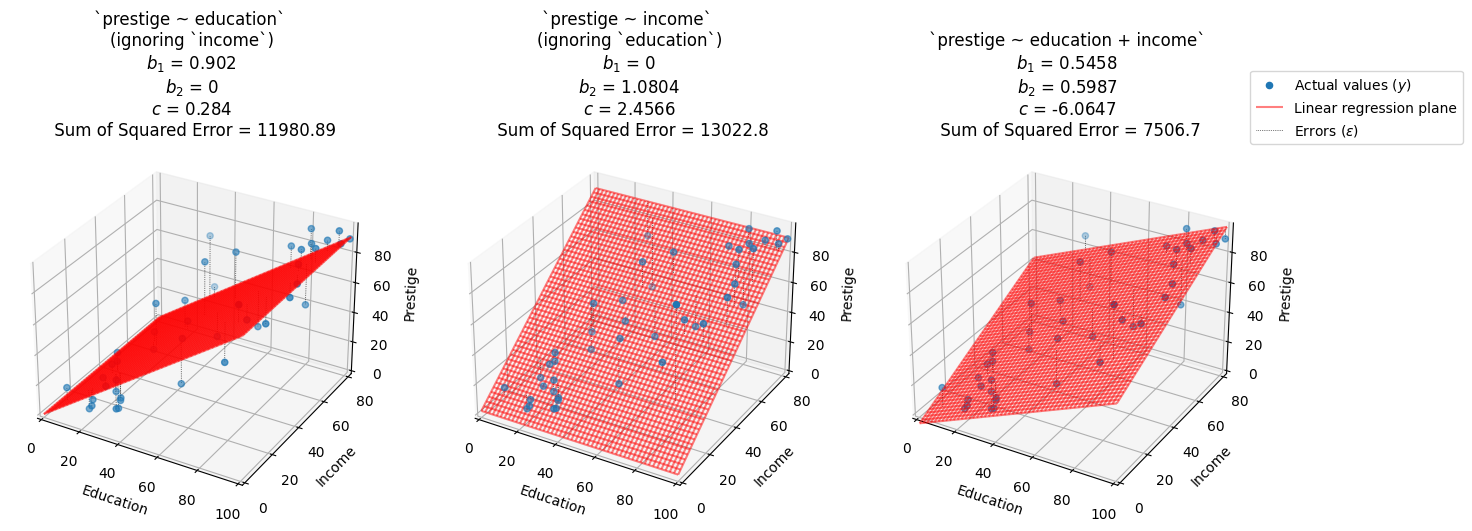

In [31]:
# generate the plot
single_multi_comparison_subplots()

The cell below let's you use a drop down menu to select which model is fit to the data, you can then "move around" the plot, to get a better understanding of the concepts just outlined above.

The regression plane is also shown, along with the errors (as black dashed lines) for whatever model you have selected.

**Pause for thought:** we recommend spending some time with this interactive plot. Changing the model and exploring each graph. Refer to the "static" plots shown above, which depict the same models.

We also recommend adjusting the plot so it is as if you are "standing" on one of the axes, as was shown the figures above. If you select one of the single predictor models, then "stand" on the axis for the predictor in the model (e.g. if you select the `prestige ~ income` model, then "stand" on the `income` axis), what you will see is equivalent to the bivariate scatterplot for that model...:

In [32]:
# generate the interactive plot
def duncan_plotly(model = ["`prestige ~ education` \n(ignoring `income`)",
                           "`prestige ~ income` \n(ignoring `education`)",
                            "`prestige ~ education + income`"]):
    ignore_income = "`prestige ~ education` \n(ignoring `income`)"
    ignore_education = "`prestige ~ income` \n(ignoring `education`)"
    adjust = "`prestige ~ education + income`"
    if model == ignore_income:
        plotly_3D_with_plane(dataset=duncan,
                         x1_string='education',
                         x2_string='income',
                         y_string='prestige',
                        hover_string_list=['name'],
                        x1_slope=duncan_prestige_education_slope,
                        x2_slope=0,
                        intercept=duncan_prestige_education_intercept,
                        model_title_string=ignore_income)

    elif model == ignore_education:
        plotly_3D_with_plane(dataset=duncan,
                         x1_string='education',
                         x2_string='income',
                         y_string='prestige',
                        hover_string_list=['name'],
                        x1_slope=0,
                        x2_slope=duncan_prestige_income_slope,
                        intercept=duncan_prestige_income_intercept,
                        model_title_string=ignore_education)

    elif model == adjust:
        plotly_3D_with_plane(dataset=duncan,
                         x1_string='education',
                         x2_string='income',
                         y_string='prestige',
                        hover_string_list=['name'],
                        x1_slope=duncan_prestige_education_income_ed_slope,
                        x2_slope=duncan_prestige_education_income_inc_slope,
                        intercept=duncan_prestige_education_income_intercept,
                        model_title_string=adjust)
interact(duncan_plotly)

interactive(children=(Dropdown(description='model', options=('`prestige ~ education` \n(ignoring `income`)', '…

<function __main__.duncan_plotly(model=['`prestige ~ education` \n(ignoring `income`)', '`prestige ~ income` \n(ignoring `education`)', '`prestige ~ education + income`'])>

This is the process of statistical adjustment. The fitting process takes into account other predictor variables, rather than ignoring them.

This let's us make statements like:


- "based on our model and data, if we compared two observational units that differed only by one unit on `education`, and had the same `income` score, we would predict their difference in `prestige` to be $b_1$" (where $b_1$ is the slope for `education`)


- "based on our model and data, if we compared two observational units that differed only by one unit on `income`, and had the same `education` score, we would predict their difference in `prestige` to be $b_2$" (where $b_2$ is the slope for `income`)

In the present case, we can clearly see the regression plane for the two-predictor model (`prestige ~ education + income`) has been adjusted relative to the regression planes for the single predictor models. (Just to note again, for each single-predictor model, the slope of the other predictor is set to 0, which is means it is ignored, the plane does not take into account information from the other predictor).

Statistical adjustment in this case has affect the *magnitude* but not the direction (the +/- sign) of the slope of each predictor.

However, statistical adjustment *can* also affect the direction of the slope, as we will see in the final section of this page.

First though, let's explore statistical adjustment in a multi-predictor linear regression model, where one of the predictors is a *categorical* variable.

## Statistical adjustment, with continuous and categorical predictors

To demonstrate how statistical adjustment works when we include a categorical predictor in a multi-predictor regression model, we'll use the Duncan data, but will restrict our analysis only to observational units that score either "blue collar" (`bc`) or "profession" (`prof`) on the `type` variable. This allows us to just use one dummy variable, which is simpler to visualise, but the princple extends to including additional categorical predictors.

To code cell below selects rows of the `duncan` dataframe which are either `bc` or `prof`:

In [33]:
# restrict analysis to just `bc` and `prof` occupations
duncan_bc_prof = duncan[(duncan['type'] == 'bc') | (duncan['type'] == 'prof')].copy()

# show the dataframe, first 20 values
duncan_bc_prof.head(20)

name  type  income  education  prestige
0       accountant  prof      62         86        82
1            pilot  prof      72         76        83
2        architect  prof      75         92        90
3           author  prof      55         90        76
4          chemist  prof      64         86        90
5         minister  prof      21         84        87
6        professor  prof      64         93        93
7          dentist  prof      80        100        90
9         engineer  prof      72         86        88
10      undertaker  prof      42         74        57
11          lawyer  prof      76         98        89
12       physician  prof      76         97        97
13  welfare.worker  prof      41         84        59
14         teacher  prof      48         91        73
16      contractor  prof      53         45        76
17   factory.owner  prof      60         56        81
18   store.manager  prof      42         44        45
19          banker  prof      78         82        92
24       carpenter    bc      21         23        33
25     electrician    bc      47         39        53

Now, let's create a dummy variable for `type`, according to this procedure:

$\text{For each observation, $i$, in the `type` vector:}$

 `type_dummy` $ = \begin{cases} 1, & \text{if $i$ is `bc`} \\ 0, & \text{if $i$ is `prof`} \end{cases} $

So, the dummy variable will equal 1 for `bc` occupations, and will equal 0 for `prof` occupations:

In [34]:
# create a dummy variable
duncan_bc_prof['type_dummy'] = duncan_bc_prof['type'].replace(['prof', 'bc'], [0, 1]).values

# show the dataframe, first 20 values
duncan_bc_prof.head(20)

name  type  income  education  prestige  type_dummy
0       accountant  prof      62         86        82           0
1            pilot  prof      72         76        83           0
2        architect  prof      75         92        90           0
3           author  prof      55         90        76           0
4          chemist  prof      64         86        90           0
5         minister  prof      21         84        87           0
6        professor  prof      64         93        93           0
7          dentist  prof      80        100        90           0
9         engineer  prof      72         86        88           0
10      undertaker  prof      42         74        57           0
11          lawyer  prof      76         98        89           0
12       physician  prof      76         97        97           0
13  welfare.worker  prof      41         84        59           0
14         teacher  prof      48         91        73           0
16      contractor  prof      53         45        76           0
17   factory.owner  prof      60         56        81           0
18   store.manager  prof      42         44        45           0
19          banker  prof      78         82        92           0
24       carpenter    bc      21         23        33           1
25     electrician    bc      47         39        53           1

We now have less rows of data than for the full dataset (as we've dropped the "white collar" `wc` rows):

In [35]:
duncan_bc_prof['type'].value_counts()

type
bc      21
prof    18
Name: count, dtype: int64

We're going to investigate the relationship between `prestige` (as our outcome variable) and `type_dummy` and `education` (as our predictors).

As before, we'll first fit two separate single predictor linear regression models. We'll then fit a multi-predictor linear regression model, including both the predictors from the single predictor models. This will allow us to see the effects of statistical adjustment on the parameter estimates.

Let's pull out our arrays from the `duncan_prof_bc` dataframe as normal (we'll pull out the `prestige` and `education` scores and store them as `prestige_2` and `education_2`, as there are now less values, after dropping the `wc` rows).

In [36]:
# store the type dummy as a variable
type_dummy = duncan_bc_prof['type_dummy'].values

# show the values
type_dummy

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [37]:
# get the `prestige` values, from the `duncan_bc_prof` dataframe
prestige_2 = duncan_bc_prof['prestige'].values

# show the values
prestige_2

array([82, 83, 90, 76, 90, 87, 93, 90, 88, 57, 89, 97, 59, 73, 76, 81, 45,
       92, 33, 53, 67, 57, 26, 29, 10, 15, 19, 10, 13, 24, 20,  7,  3, 16,
        6, 11,  8, 41, 10])

In [38]:
# get the `income` values, from the `duncan_bc_prof` dataframe
education_2 = duncan_bc_prof['education'].values

# show the values
education_2

array([ 86,  76,  92,  90,  86,  84,  93, 100,  86,  74,  98,  97,  84,
        91,  45,  56,  44,  82,  23,  39,  28,  32,  22,  25,  29,   7,
        26,  19,  15,  20,  26,  28,  17,  22,  30,  25,  20,  47,  32])

## Prestige ~ Type (ignoring Education)

We'll first fit a single predictor linear regression of the following form:

`prestige` = $b * $ `type_dummy` + $ \text{c} + \vec{\varepsilon} $

As we know, this single predictor linear regression will *ignore* other potential predictors in the dataset. We'll use our fitting function again:

In [39]:
# fit the `prestige ~ type` model
(duncan_prestige_type,
 duncan_prestige_type_intercept,
 duncan_prestige_type_slope)= fit_model(model_spec_string='prestige ~ type_dummy',
                                  dataset=duncan_bc_prof,
                                  slope_names_list=['type_dummy'])

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               prestige   R-squared:                       0.765
Model:                            OLS   Adj. R-squared:                  0.759
No. Observations:                  39   F-statistic:                     120.5
Covariance Type:            nonrobust   Prob (F-statistic):           3.40e-13
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     80.4444      3.856     20.862      0.000      72.632      88.257
type_dummy   -57.6825      5.255    -10.977      0.000     -68.330     -47.035
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We'll plot the data, along with the regression line:

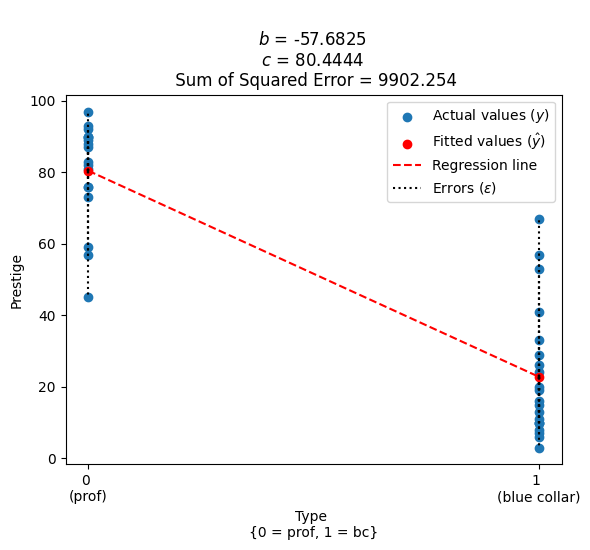

In [40]:
# do not worry about this code, it is just some convenience plotting functions
def simple_scatter_with_dummy():
    plt.scatter(type_dummy, prestige_2)
    plt.xticks([0, 1])
    plt.xlabel('Type \n{0 = prof, 1 = bc}')
    plt.ylabel('Prestige')

def with_errors_categorical(b, c, error_vector=False, show=True, show_model=False, round_to=4):
    # create the scatterplot
    simple_scatter_with_dummy()
    # add a legend label for the datapoints
    plt.scatter([], [], color = '#1f77b4', label='Actual values ($y$)')
    # set the x axis to only show a "tick" at 0 and 1
    plt.xticks([0, 1], labels = ["0 \n(prof)", "1 \n(blue collar)"])
    # plot the fitted values, from b and c
    plt.scatter([0, 1], [b * 0 + c, b * 1 + c],
            color='red', label = 'Fitted values ($\hat{y}$)')
    plt.plot(np.linspace(0, 1), b * np.linspace(0, 1) + c,
         color='red', label = 'Regression line', linestyle='--')
    fitted = b * type_dummy + c
    # plot the distance between predicted and actual, for all points.
    n = len(type_dummy)
    for i in range(n):
        plt.plot([type_dummy[i], type_dummy[i]], [fitted[i], prestige_2[i]], 'k:')
    # the following code line is just to trick Matplotlib into making a new
    # a single legend entry for the dotted lines.
    plt.plot([], [], 'k:', label='Errors ($ \\varepsilon $)')
    errors = prestige_2 - fitted
    plt.legend()
    plt.title(f"\n$b$ = {round(b, round_to)} \n$c$ = {round(c,round_to)} \n Sum of Squared Error = {round(sum(errors**2), round_to)}")
    if show == True:
        plt.show()
    if error_vector == True:
        jupyprint(f"Here is the error vector for the current line: {arraytex(np.atleast_2d(errors.round(round_to)).T)}")
    if show_model == True:
        jupyprint(f"${arraytex(np.atleast_2d(prestige_2.round(round_to)).T)} = {round(b, round_to)} * {arraytex(np.atleast_2d(type_dummy).T)} + {round(c, round_to)} + {arraytex(np.atleast_2d(prestige_2 - fitted).round(round_to).T)}$")

with_errors_categorical(duncan_prestige_type_slope, duncan_prestige_type_intercept)

## Prestige ~ Education (Ignoring Type)

Now we'll fit a separate single-predictor linear regression model of the form:

`prestige` = $b * $ `type_education` + $ \text{c} + \vec{\varepsilon} $


In [41]:
# fit the `prestige ~ education` model
(duncan_prestige_education_2,
 duncan_prestige_education_2_intercept,
 duncan_prestige_education_2_slope)= fit_model(model_spec_string='prestige ~ education',
                                  dataset=duncan_bc_prof,
                                  slope_names_list=['education'])

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               prestige   R-squared:                       0.801
Model:                            OLS   Adj. R-squared:                  0.795
No. Observations:                  39   F-statistic:                     148.5
Covariance Type:            nonrobust   Prob (F-statistic):           1.62e-14
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2677      4.699      0.057      0.955      -9.252       9.788
education      0.9597      0.079     12.185      0.000       0.800       1.119
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We'll plot the regression line, and the data, for this model:

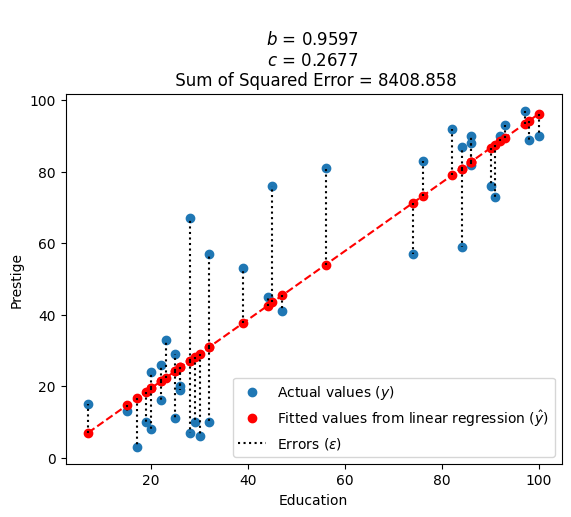

In [42]:
# do not worry about this code it just generates the plot
def make_scatter_2(x, y, b, c, with_errors = True, show = False,
                 xlabel='Education',
                 ylabel='Prestige',
                 x_0_1=False,
                 rev_min_max=False,
                 show_fitted=True,
                 round_to=4):
    plt.scatter(x, y, label='Actual values ($y$)')
    # plot the predicted values
    fitted = b * x + c
    errors = y -fitted
    if show_fitted == True:
        plt.plot(x, fitted, 'ro', label='Fitted values from linear regression ($\hat{y}$)')
    if rev_min_max == False:
        plt.plot([x.min(), x.max()], [fitted.min(), fitted.max()], linestyle = '--', color = 'red')
    if rev_min_max == True:
        plt.plot([x.min(), x.max()], [fitted.max(), fitted.min()], linestyle = '--', color = 'red')
    if with_errors == True:
        # plot the distance between predicted and actual, for all points.
        n = len(x)
        for i in range(n):
            plt.plot([x[i], x[i]], [fitted[i], y[i]], 'k:')
        # the following code line is just to trick Matplotlib into making a new
        # a single legend entry for the dotted lines.
        plt.plot([], [], 'k:', label='Errors ($ \\varepsilon $)')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(f"\n$b$ = {round(b, round_to)} \n$c$ = {round(c,round_to)} \n Sum of Squared Error = {round(sum(errors**2), round_to)}")
    if x_0_1 == True:
        plt.xticks([0, 1])
    # show the legend
    plt.legend();
    if show == True:
        plt.show()
make_scatter_2(education_2, prestige_2, duncan_prestige_education_2_slope, duncan_prestige_education_2_intercept)

## Prestige ~ Type + Education

Now we'll include both predictors in the same model, so we can see the effects of statistical adjustment when a categorical predictor is involved:

`prestige` = $b_1 * $ `type_dummy` + $b_2 * $ `education` $ \text{c} + \vec{\varepsilon} $

In [43]:
# fit the `prestige ~ type + education` model
(duncan_prestige_type_education,
 duncan_prestige_type_education_intercept,
 duncan_prestige_type_education_type_slope,
duncan_prestige_type_education_ed_slope)= fit_model(model_spec_string='prestige ~ type_dummy + education',
                                                    dataset=duncan_bc_prof,
                                                    slope_names_list=['type_dummy', 'education'])

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               prestige   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.812
No. Observations:                  39   F-statistic:                     82.82
Covariance Type:            nonrobust   Prob (F-statistic):           3.40e-14
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     30.2551     15.271      1.981      0.055      -0.716      61.227
type_dummy   -23.1260     11.253     -2.055      0.047     -45.947      -0.305
education      0.6171      0.183      3.372      0.002       0.246       0.988
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

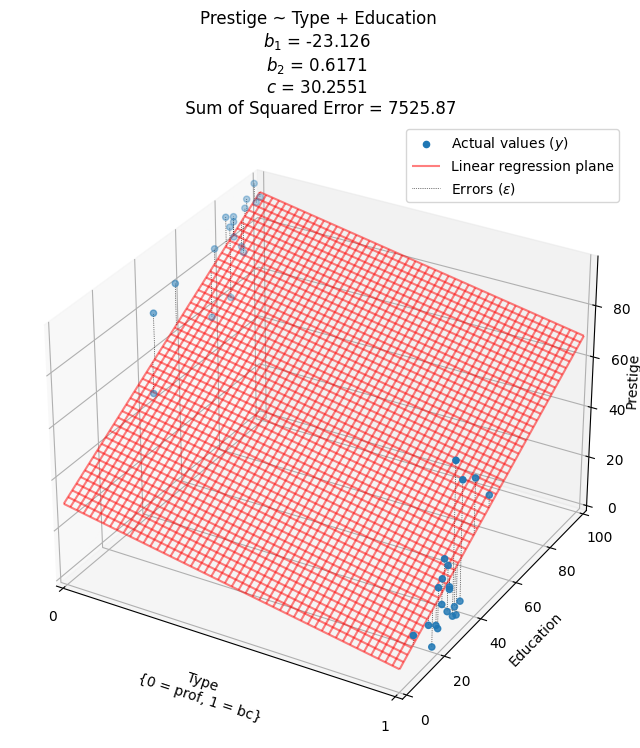

In [44]:
# do not worry about this code, it just generates the plot
make_3d_scatter(x1=type_dummy,
                x2=education_2,
                y=prestige_2,
                x1_slope=duncan_prestige_type_education_type_slope,
                x2_slope=duncan_prestige_type_education_ed_slope,
                c=duncan_prestige_type_education_intercept,
                model_string='Prestige ~ Type + Education',
                x1_label='Type \n{0 = prof, 1 = bc}',
                x2_label='Education',
                y_label='Prestige',
               x1_1_or_0=True)

The code cell below plots all these models on side-by-side graphs.

The leftmost graph shows the `prestige ~ education` model (so the regression plane ignores the `type` variable).

The middle graph shows the `prestige ~ type` model (so the regression plane ignores the `education` variable)

The rightmost graph shows the multi-predictor model `prestige ~ type + education`, so we can see how the regression plane and parameter estimates are adjusted when we include both predictors:

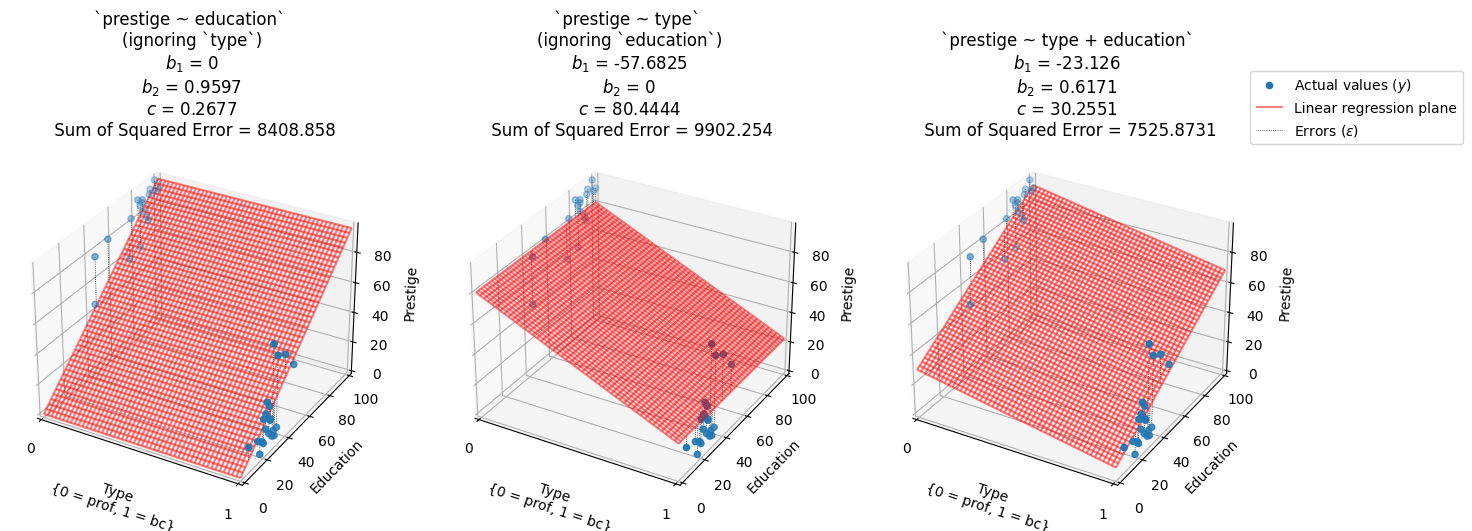

In [45]:
# do not worry about this code, it is just to generate the 3D plots
def single_multi_comparison_subplots_2(x1 = type_dummy, x2 = education_2, y = prestige_2,
                                     x1_label='Type\n{0 = prof, 1 = bc}',
                                       x2_label='Education',
                                       y_label='Prestige',
                                       plane_alpha=0.5,
                                     round_to=4):
    model_strings = ["`prestige ~ education` \n(ignoring `type`)",
                     "`prestige ~ type` \n(ignoring `education`)",
                     "`prestige ~ type + education`"]
    fig, axes = plt.subplots(1, 3, figsize=(16, 10), subplot_kw={'projection': '3d'})

    for num, (subplot_val, x1_slope, x2_slope, c) in enumerate(zip([131, 132, 133],
                                                        [0, duncan_prestige_type_slope, duncan_prestige_type_education_type_slope],
                                                        [duncan_prestige_education_2_slope, 0, duncan_prestige_type_education_ed_slope],
                                                        [duncan_prestige_education_2_intercept, duncan_prestige_type_intercept, duncan_prestige_type_education_intercept])):
        sum_sq = ss_two_predictors([x1_slope, x2_slope, c], x1, x2, y)
        ax = axes[num]
        ax.scatter(x1,x2,y, label = 'Actual values ($y$)')
        ax.set_xticks([0, 1])
        ax.set_xlabel(x1_label)
        ax.set_ylabel(x2_label)
        ax.set_zlabel(y_label)
        mx_x1 = x1.max()
        mx_x2 = x2.max()
        mx_y = y.max()
        # Plot the fitting plane.
        plane_x = np.linspace(0, mx_x1, 50)
        plane_y = np.linspace(0, mx_x2, 50)
        X, Y = np.meshgrid(plane_x, plane_y)
        Z = c + x1_slope * X + x2_slope * Y
        ax.plot_wireframe(X,Y,Z, color = 'red', label = 'Linear regression plane', alpha = plane_alpha)
        # Plot lines between each point and fitting plane
        for i in np.arange(len(y)):
            x1_point, x2_point, actual = x1[i], x2[i], y[i]
            fitted = c + x1_point * x1_slope + x2_point * x2_slope
            ax.plot([x1_point, x1_point], [x2_point, x2_point], [fitted, actual],
                    linestyle=':',
                    linewidth=0.5,
                    color='black')
        # add labels to error
        ax.plot([], [], [],
            linestyle=':',
            linewidth=0.5,
            color='black',
            label='Errors ($ \\varepsilon $)')
        # Set the axis limits
        ax.set_xlim(0, mx_x1)
        ax.set_ylim(0, mx_x2)
        ax.set_zlim(0, mx_y)
        ax.set_title(f"{model_strings[num]}\n$b_1$ = {round(x1_slope,round_to)} \n$b_2$ = {round(x2_slope,round_to)} \n$c$ = {round(c,round_to)} \n Sum of Squared Error = {round(sum_sq, round_to)}")
    plt.legend(loc = (1,  1))

single_multi_comparison_subplots_2()

Once again, let's imagine these plots as physical objects, where you could stand on one of the axes, and look
at the plot:

![](images/stat_adjust_duncan_type_ed.png)

The person on the leftmost plot (dressed in blue) would see something like this (again, pay attention to the parameter estimates and sum of squared error value, shown in the title of both plots):

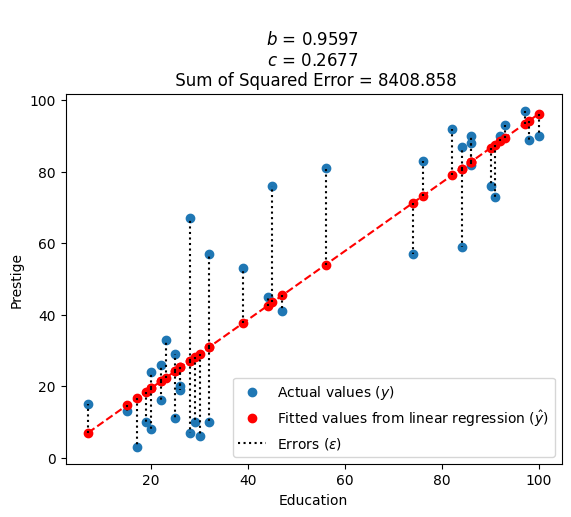

In [46]:
# generate the plot
make_scatter_2(education_2, prestige_2, duncan_prestige_education_2_slope, duncan_prestige_education_2_intercept)

Let's consider what the person on the middle plot (the ghostly figure dressed in black) would see:

![](images/stat_adjust_duncan_type_ed.png)

They would see something like this:

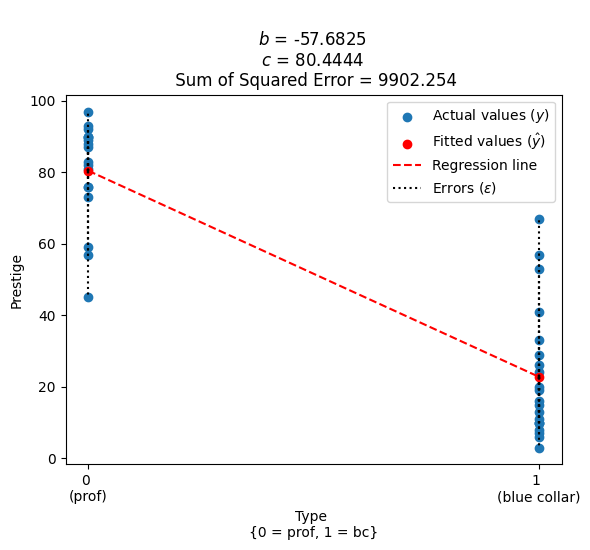

In [47]:
# generate the plot
with_errors_categorical(duncan_prestige_type_slope, duncan_prestige_type_intercept)

The cell below has an interactive dropdown menu that allows you to select a model one of the three models we have just fit.The plot shows the regression plane for the model you've selected from the dropdown menu, and once again it displays errors as black dashed lines.

**Pause for thought**: once again please take your time to interact carefully with this plot. Change the model selection and explore each graph. Please also refer to the three side-by-side static plots presented above, which represent the same models.

We recommend adjusting the plot as if you are "positioned" on one of the axes, similar to the illustrations shown earlier. For example, if you choose one of the single predictor models, "position" yourself on the axis corresponding to the predictor in the model (e.g., if you select the `prestige ~ type` model, then "position" yourself on the `type` axis). What you will observe is equivalent to the bivariate scatterplot for that specific model, which are shown in the cells above this one:

In [48]:
# generate the interactive plot
def duncan_plotly_categorical(model = ["`prestige ~ education` \n(ignoring `type`)",
                                       "`prestige ~ type` \n(ignoring `education`)",
                                       "`prestige ~ type + education`"]):
    ignore_type = "`prestige ~ education` \n(ignoring `type`)"
    ignore_education = "`prestige ~ type` \n(ignoring `education`)"
    adjust = "`prestige ~ type + education`"
    if model == ignore_type:
        plotly_3D_with_plane(dataset=duncan_bc_prof,
                         x1_string='type_dummy',
                         x2_string='education',
                         y_string='prestige',
                        hover_string_list=['name'],
                        x1_slope=0,
                        x2_slope=duncan_prestige_education_2_slope,
                        intercept=duncan_prestige_education_2_intercept,
                        model_title_string=ignore_type,
                        x1_1_or_0=True)

    elif model == ignore_education:
        plotly_3D_with_plane(dataset=duncan_bc_prof,
                         x1_string='type_dummy',
                         x2_string='education',
                         y_string='prestige',
                        hover_string_list=['name'],
                        x1_slope=duncan_prestige_type_slope,
                        x2_slope=0,
                        intercept=duncan_prestige_type_intercept,
                        model_title_string=ignore_education,
                        x1_1_or_0=True)

    elif model == adjust:
        plotly_3D_with_plane(dataset=duncan_bc_prof,
                         x1_string='type_dummy',
                         x2_string='education',
                         y_string='prestige',
                        hover_string_list=['name'],
                        x1_slope=duncan_prestige_type_education_type_slope,
                        x2_slope=duncan_prestige_type_education_ed_slope,
                        intercept=duncan_prestige_type_education_intercept,
                        model_title_string=adjust,
                        x1_1_or_0=True)
interact(duncan_plotly_categorical)

interactive(children=(Dropdown(description='model', options=('`prestige ~ education` \n(ignoring `type`)', '`p…

<function __main__.duncan_plotly_categorical(model=['`prestige ~ education` \n(ignoring `type`)', '`prestige ~ type` \n(ignoring `education`)', '`prestige ~ type + education`'])>

## Statistical adjustment, with the EPL data, continuous predictors

Just as a final illustration, to help you visualise what is happening in a case where statisticla adjustment *reverses* one of the slopes (e.g. changes it's +/- sign), we will return the English Premier League (EPL) data that we have seen previously.

The data details wage spends in the 2021-2022 year for EPL football clubs. The observational units are football clubs, and the variables we are interested in are:

`goal_difference` - the difference between the goals scored and goals conceded. This is a metric of performance (high, positive values indicate better performance.

`forward` - the club's wage spending on attacking players

`defense` the club's wage spending on defensive players

See [the EPL dataset
page](https://github.com/odsti/datasets/tree/main/premier_league) for more
details.

Let's import the data:

In [49]:
# import the data
epl = pd.read_csv('data/premier_league_2021.csv')
epl.head()

rank               team  played  won  drawn  lost  for  against  \
0     1    Manchester City      38   29      6     3   99       26   
1     2          Liverpool      38   28      8     2   94       26   
2     3            Chelsea      38   21     11     6   76       33   
3     4  Tottenham Hotspur      38   22      5    11   69       40   
4     5            Arsenal      38   22      3    13   61       48   

   goal_difference  points  wages_year  keeper  defense  midfield  forward  
0               73      93      168572    8892    60320     24500    74860  
1               68      92      148772   14560    46540     47320    40352  
2               43      74      187340   12480    51220     51100    72540  
3               29      71      110416    6760    29516     30680    43460  
4               13      69      118074    8400    37024     27300    45350

And let's pull out the variables of interest, and store them as python variables, to save us typing:

In [50]:
# store the `goal_difference` variable as an array
goal_difference = epl['goal_difference'].values

# store the `defense` variable as an array
defense = epl['defense'].values

# store the `forward` variable as an array
forward = epl['forward'].values

We fit with the now familiar sequence:

- two single-predictor models
- one multi-predictor model, including both the predictors from the separate single-predictor models

This will enable us to visualise the effects of statistical adjustment.


## Goal Difference ~ Forward

First, we will fit the following single-predictor model:

`goal_difference` = $b * $ `forward` + $ \text{c} + \vec{\varepsilon} $

In [51]:
# fir the `goal_difference ~ forward" model
(epl_goaldiff_forward,
epl_goaldiff_forward_intercept,
epl_goaldiff_forward_slope) = fit_model(model_spec_string='goal_difference ~ forward',
                                  dataset=epl,
                                  slope_names_list=['forward'])

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        goal_difference   R-squared:                       0.332
Model:                            OLS   Adj. R-squared:                  0.295
No. Observations:                  20   F-statistic:                     8.934
Covariance Type:            nonrobust   Prob (F-statistic):            0.00787
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -25.7248     10.698     -2.405      0.027     -48.200      -3.250
forward        0.0007      0.000      2.989      0.008       0.000       0.001
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.23e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

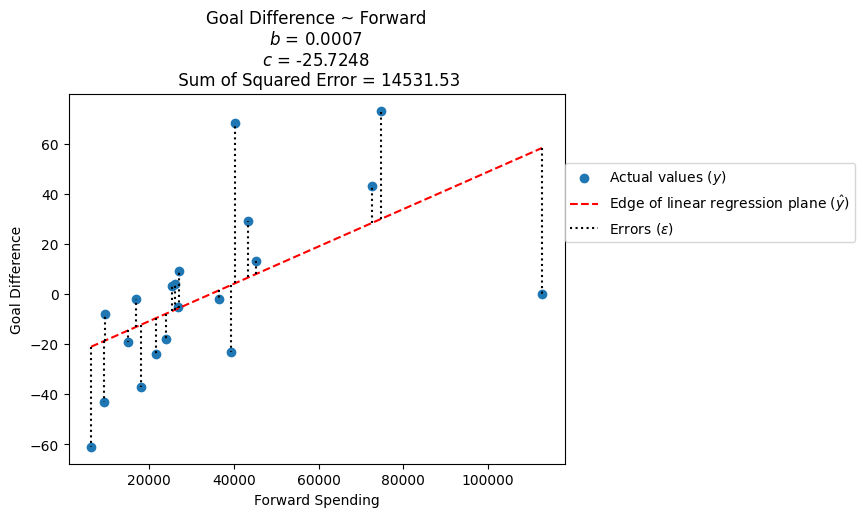

In [52]:
# generate the plot
def plot_goaldiff_forward(continuous_line=False):
    make_scatter(x=forward,
    y=goal_difference,
    b=epl_goaldiff_forward_slope,
    c=epl_goaldiff_forward_intercept,
    xlabel='Forward Spending',
    ylabel='Goal Difference',
    with_errors=True,
    model_string='Goal Difference ~ Forward',
    continuous_line=continuous_line,
    round_to=4)

plot_goaldiff_forward(continuous_line=True)

We can see that, if we ignore `defense`, there is a positive linear relationship between `forward` and `goal_difference`.


## Goal Difference ~ Defense

Now let's fit the following single-predictor model:

`goal_difference` = $b * $ `defense` + $ \text{c} + \vec{\varepsilon} $

In [53]:
# fit the `goal_difference ~ defense` model
(epl_goaldiff_defense,
epl_goaldiff_defense_intercept,
epl_goaldiff_defense_slope) = fit_model(model_spec_string='goal_difference ~ defense',
                                  dataset=epl,
                                  slope_names_list=['defense'])

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        goal_difference   R-squared:                       0.549
Model:                            OLS   Adj. R-squared:                  0.524
No. Observations:                  20   F-statistic:                     21.94
Covariance Type:            nonrobust   Prob (F-statistic):           0.000185
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -45.2366     10.976     -4.121      0.001     -68.297     -22.176
defense        0.0016      0.000      4.684      0.000       0.001       0.002
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.75e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

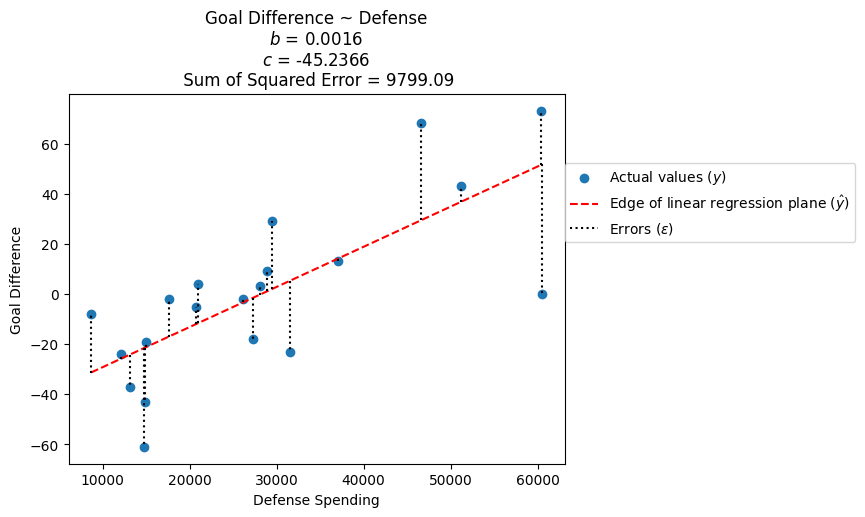

In [54]:
# generate the plot
def plot_goaldiff_defense(continuous_line=False):
    make_scatter(x=defense,
    y=goal_difference,
    b=epl_goaldiff_defense_slope,
    c=epl_goaldiff_defense_intercept,
    xlabel='Defense Spending',
    ylabel='Goal Difference',
    with_errors=True,
    model_string='Goal Difference ~ Defense',
    continuous_line=continuous_line,
    round_to=4)

plot_goaldiff_defense(continuous_line=True)

For this model, there is a positive linear association between `defense` and `goal_difference` (ignoring `forward`).


## Goal Difference ~ Forward + Defense

First, we will fit the following single-predictor model:

`goal_difference` = $b_1 * $ `forward` + $ + b_2 *$  `defense` + $ \text{c} + \vec{\varepsilon} $

As we've seen previously, this now takes into account both predictors *at the same time* when fitting the model:

In [55]:
# fit the multi-predictor model
(epl_goaldiff_forward_defense,
epl_goaldiff_forward_defense_intercept,
epl_goaldiff_forward_defense_slope_forw,
epl_goaldiff_forward_defense_slope_def) = fit_model(model_spec_string='goal_difference ~ forward + defense',
                                          dataset=epl,
                                          slope_names_list=['forward', 'defense'])

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        goal_difference   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.575
No. Observations:                  20   F-statistic:                     13.85
Covariance Type:            nonrobust   Prob (F-statistic):           0.000270
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -52.8752     11.236     -4.706      0.000     -76.581     -29.169
forward       -0.0009      0.000     -1.772      0.094      -0.002       0.000
defense        0.0029      0.001      3.587      0.002       0.001       0.005
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.21e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

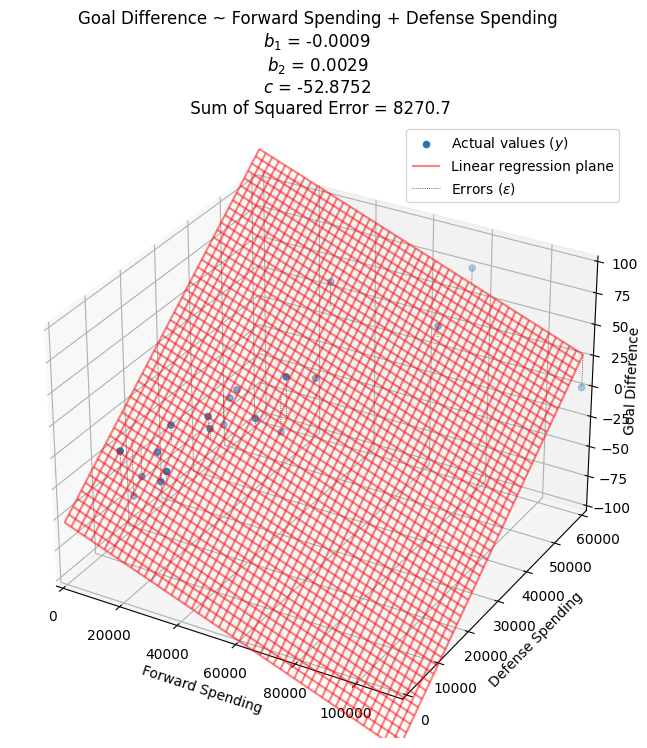

In [56]:
# plot the multi-predictor model
make_3d_scatter(x1=forward,
                x2=defense,
                y=goal_difference,
                x1_slope=epl_goaldiff_forward_defense_slope_forw,
                x2_slope=epl_goaldiff_forward_defense_slope_def,
                c=epl_goaldiff_forward_defense_intercept,
                x1_label='Forward Spending',
                x2_label='Defense Spending',
                y_label='Goal Difference',
                model_string='Goal Difference ~ Forward Spending + Defense Spending',
                round_to=4,
                mx_y=100,
                min_y=-100)

We can see that the slope for `forward` is now *negative*, once we include `defense` in the model.

Let's look at all the models, side-by-side, in 3D, so we can see how the regression plane has been adjusted in the multi-predictor model:

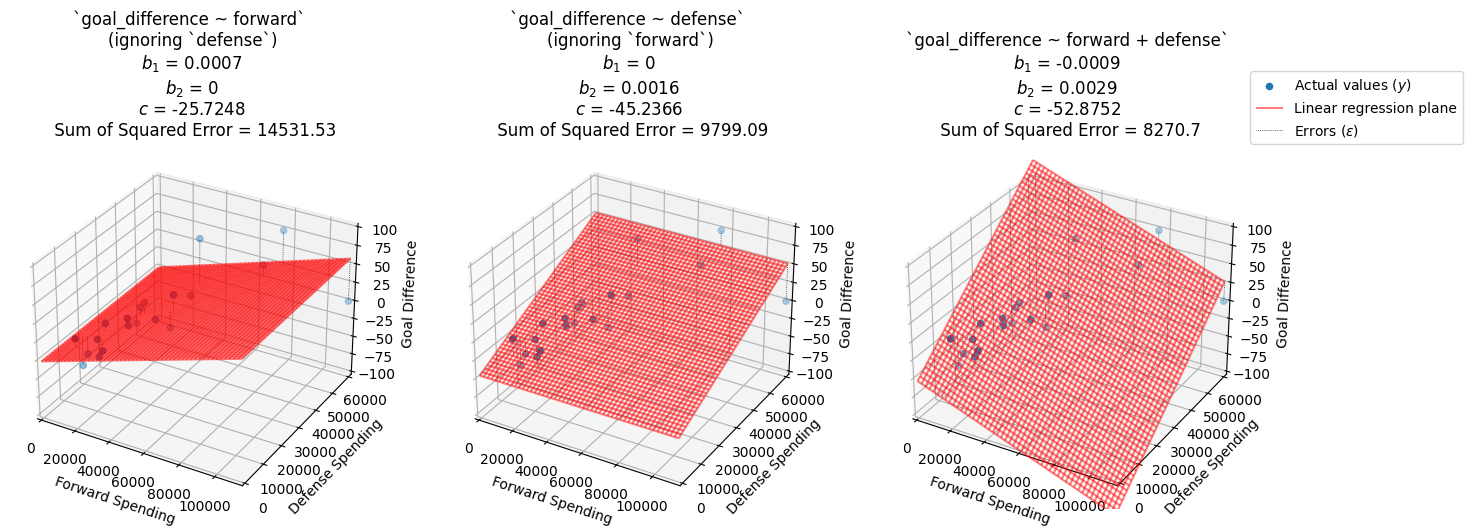

In [57]:
# generate the plot
single_multi_comparison_subplots(x1=forward,
                                 x2=defense,
                                 y=goal_difference,
                                 x1_label='Forward Spending',
                                 x2_label='Defense Spending',
                                 y_label='Goal Difference',
                                 round_to=4,
                                 mx_y=100,
                                 min_y=-100,
                                 model_strings=["`goal_difference ~ forward` \n(ignoring `defense`)",
                                                         "`goal_difference ~ defense` \n(ignoring `forward`)",
                                                         "`goal_difference ~ forward + defense`"],
                                    x1_slopes=[epl_goaldiff_forward_slope, 0, epl_goaldiff_forward_defense_slope_forw],
                                    x2_slopes=[0, epl_goaldiff_defense_slope, epl_goaldiff_forward_defense_slope_def],
                                    cs=[epl_goaldiff_forward_intercept, epl_goaldiff_defense_intercept,
                                          epl_goaldiff_forward_defense_intercept])

In the cell below, you'll once again find an interactive dropdown menu that lets you to select one of the three models shown on the plot above this cell.

**Pause for thought**: we *especially* encourage you to spend a lot of time interacting with this plot, with the same considerations as for the previous interactive plots.

Switch between the models and try to develop an intution for how the distribution of the points causes the direction of the `forward` slope to reverse, in the multi-predictor model, relative to the single predictor model.

In [58]:
# generate the interactive plot
def epl_plotly(model = ["`goal_difference ~ forward` \n(ignoring `defense`)",
                           "`goal_difference ~ defense` \n(ignoring `forward`)",
                            "`goal_difference ~ forward + defense`"]):

    ignore_defense = "`goal_difference ~ forward` \n(ignoring `defense`)"
    ignore_forward = "`goal_difference ~ defense` \n(ignoring `forward`)"
    adjust = "`goal_difference ~ forward + defense`"
    if model == ignore_defense:
        plotly_3D_with_plane(dataset=epl,
                         x1_string='forward',
                         x2_string='defense',
                         y_string='goal_difference',
                        hover_string_list=['team'],
                        x1_slope=epl_goaldiff_forward_slope,
                        x2_slope=0,
                        intercept=epl_goaldiff_forward_intercept,
                        model_title_string=ignore_defense)

    elif model == ignore_forward:
        plotly_3D_with_plane(dataset=epl,
                         x1_string='forward',
                         x2_string='defense',
                         y_string='goal_difference',
                        hover_string_list=['team'],
                        x1_slope=0,
                        x2_slope=epl_goaldiff_defense_slope,
                        intercept=epl_goaldiff_defense_intercept,
                        model_title_string=ignore_forward)

    elif model == adjust:
        plotly_3D_with_plane(dataset=epl,
                         x1_string='forward',
                         x2_string='defense',
                         y_string='goal_difference',
                        hover_string_list=['team'],
                        x1_slope=epl_goaldiff_forward_defense_slope_forw,
                        x2_slope=epl_goaldiff_forward_defense_slope_def,
                        intercept=epl_goaldiff_forward_defense_intercept,
                        model_title_string=adjust)
interact(epl_plotly)

interactive(children=(Dropdown(description='model', options=('`goal_difference ~ forward` \n(ignoring `defense…

<function __main__.epl_plotly(model=['`goal_difference ~ forward` \n(ignoring `defense`)', '`goal_difference ~ defense` \n(ignoring `forward`)', '`goal_difference ~ forward + defense`'])>